### Loading the super-tensor and creating the temporal networks

In this notebook we will explore the class __temporal_nets__ to compute preliminar results using network analysis.

In [13]:
# Importing the temporal network class
from   GDa.temporal_network              import temporal_network
from   GDa.graphics.plot_raster          import plot_nodes_raster_all_bands 
from   GDa.graphics.plot_coherence_dists import plot_pooled_coherence_dists, plot_pooled_coherence_dists_per_stage, plot_pooled_coherence_dists_per_stim
from   GDa.graphics.plot_adjacency       import plot_adjacency 
import numpy                 as     np
import networkx              as     nx
import matplotlib.pyplot     as     plt
import igraph                as     ig
import leidenalg
import scipy.signal
import time
from   tqdm                  import tqdm
from   joblib                import Parallel, delayed
from   scipy                 import stats

# Just an auxiliary function to sommoth plots
def smooth(x, w):
    return scipy.signal.fftconvolve(x, np.ones(w)/w, mode='same')
# Just an auxiliary function to compute z-score
def zscore(x):
    z = np.zeros_like(x)
    for i in range(len(z)):
        if x.std() == 0:
            continue
        else:
            z[i] = (x[i]-x.mean())/x.std()
    return z
# Bands names
bands = [r'$\theta$', r'$\alpha$', r'$\beta$', r'$\gamma$ ']

In [14]:
# Instantiating a temporal network object
net = temporal_network(monkey='lucy', session=1, date=150128)

When instantiated, the temporal network object will load the recording info for the monkey, date, and sesion specified as well as the super tensor;

The super-tensor has dimensions [Number of pairs, Number of frequency bands, Number of trials * Time] (i.e., the trials are concatenated). So far we are using the following bands:

- $\theta$  = [4,8]  Hz;
- $\alpha$  = [8,15]  Hz;
- $\beta$   = [15,30]  Hz;
- $\gamma$  = [30,60]  Hz;

It is possible to check which recording information was recordes by acessing the __session_info__ dictionary:

In [15]:
print('Recording info available:\n')
print(list(net.session_info.keys()))

Recording info available:

['nC', 'nP', 'nT', 'pairs', 'indt', 'fsample', 'tarray', 'channels_labels', 'dcue', 'dsm', 'stim', 'indch', 'areas', 't_cue_on', 't_cue_off', 't_match_on']


We can plot the super tensor to visualize the time series of link strength for each band (here we plot 10 trials for better visualization).

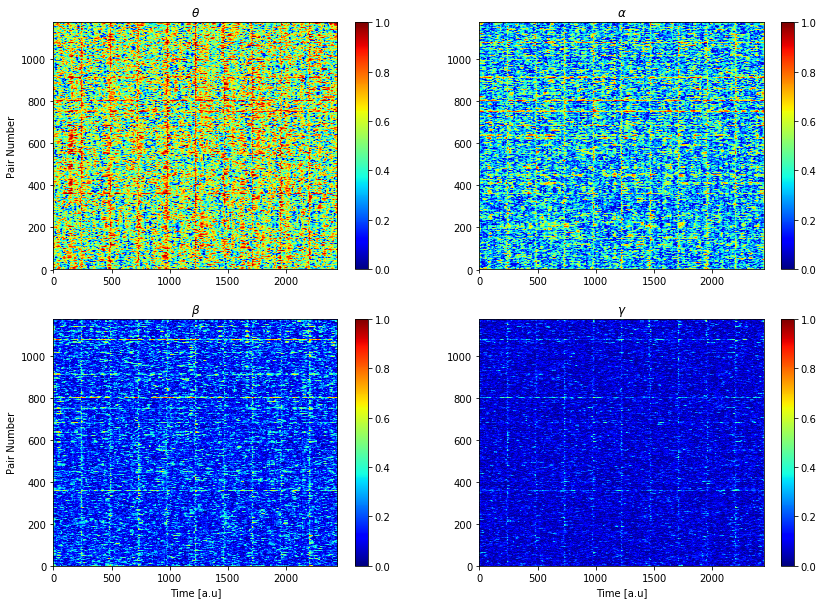

In [16]:
plot_nodes_raster_all_bands(net.super_tensor[:,:,:10*len(net.tarray)], 
                            0, 10*len(net.tarray), 
                            1, net.session_info['nP'], 0, 1, 
                            'Pair Number', 'Time [a.u]', bands, (14,10), 'jet')
plt.savefig('figures/layerwise_net/super_tensor_no_trim.png')

Notice that strong vertical stripes appear at the beggining/ending of each trial in the image above. This is due artifacts during wavelet estimation of pairwise coherences. To remove the border artifacts it is possible to instantiate the __temporal_network__ class specifing the parameter __trim_borders__ = True, and a value to the parameter __wt__. Doing that the firs and last __wt__ time points of the super tensor and the time array will be removed.

In [17]:
# Instantiating a temporal network object specifing trim_borders and wt.
net =  temporal_network(monkey='lucy', session=1, date=150128, trim_borders=True, wt=20)

Now let's plot the super tensor for the first ten trials again and observe that now the vertical stripes are gone.

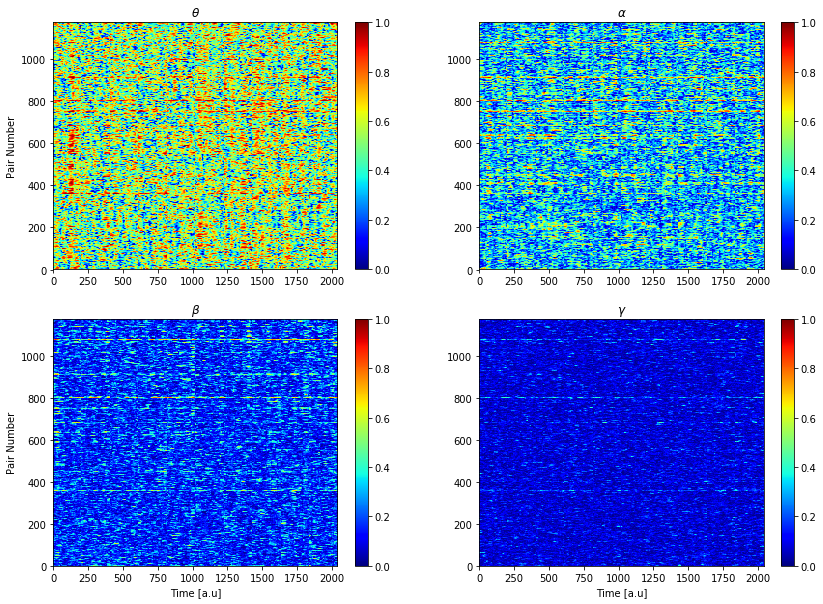

In [18]:
plot_nodes_raster_all_bands(net.super_tensor[:,:,:10*len(net.tarray)], 
                            0, 10*len(net.tarray), 
                            1, net.session_info['nP'], 0, 1, 
                            'Pair Number', 'Time [a.u]', bands, (14,10), 'jet')
plt.savefig('figures/layerwise_net/super_tensor.png')

Some of the network theory measures can be applied to the binarized version of the network and in order to do so it is necessary to define thresholds for the coherence values, this can be done with the method __compute_coherence_thresholds__, this method receives a parameter __q__ between $0$ and $1$ that specifies that only links with coherence values in the top $(1-q)$ of the distribution will be kept.

Threshold in $\delta$ band = 0.6973007619380951
Threshold in $\alpha$ band = 0.4740316814184189
Threshold in $\beta$  band = 0.2512036664145334
Threshold in $\gamma$ band = 0.12849100516239803


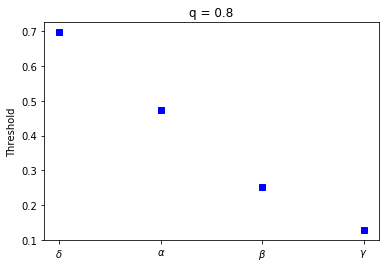

In [19]:
net.compute_coherence_thresholds(q = 0.8)

# Printing the threshold values 
print(r'Threshold in $\delta$ band = ' + str(net.coh_thr[0]))
print(r'Threshold in $\alpha$ band = ' + str(net.coh_thr[1]))
print(r'Threshold in $\beta$  band = ' + str(net.coh_thr[2]))
print(r'Threshold in $\gamma$ band = ' + str(net.coh_thr[3]))

plt.plot(range(4), net.coh_thr, 'bs')
plt.xticks(range(4), [r'$\delta$', r'$\alpha$', r'$\beta$', r'$\gamma$ '])
plt.title('q = 0.8')
plt.ylabel('Threshold')
plt.savefig('figures/layerwise_net/thresholds_q80.png')

To better visualize the threshold we can plot the pooled ditributions of coherence for each frequency band and indicate the threshold with a vertical line:

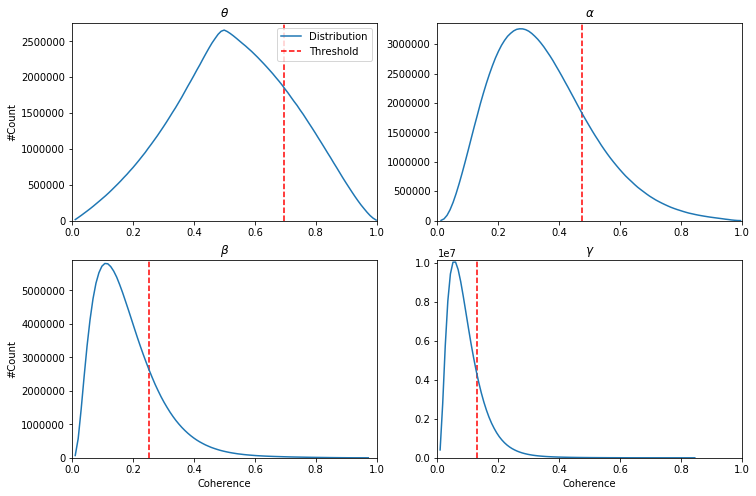

In [20]:
plot_pooled_coherence_dists(net.super_tensor, bins = 100, 
                            normed = False, 
                            thrs = [net.coh_thr[0], net.coh_thr[1], 
                                    net.coh_thr[2], net.coh_thr[3]],
                            titles = bands, figsize=(12,8))
plt.savefig('figures/layerwise_net/super_tensor_dists_thr.png')

Let's plot the binarized super tensor as well:

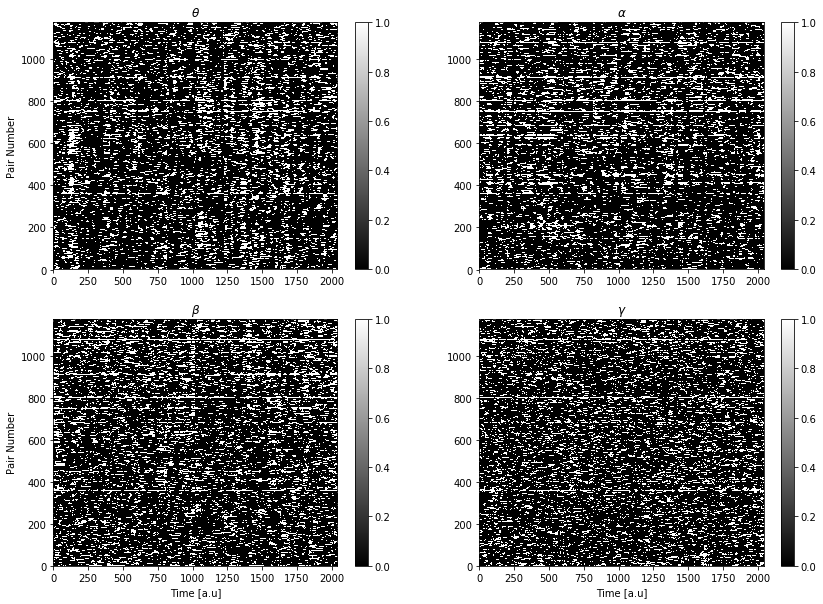

In [21]:
plot_nodes_raster_all_bands(net.super_tensor[:,:,:10*len(net.tarray)], 
                            0, 10*len(net.tarray), 
                            1, net.session_info['nP'], 0, 1, 
                            'Pair Number', 'Time [a.u]', bands, (14,10), 'gray',
                            thrs = [net.coh_thr[0], net.coh_thr[1], 
                                    net.coh_thr[2], net.coh_thr[3]],)
plt.savefig('figures/layerwise_net/super_tensor_thresholded.png')

To use the Python package networkx or igraph to compute network theory quantities it is necessary to instantiate a __Graph__ object, to do so we have to provide an adjacency matrix to the __Graph__ method. Note that the super tensor is the edge representation of the network, but we can convert it to an adjacency matrix by calling the methdo __convert_to_adjacency__ in the class __temporal_network__. This method will create the variable __A__ inside the object.

In [22]:
net.convert_to_adjacency()

The adjacency matrix has dimensions [Number of channels, Number of channels Number of frequency bands, Number of trials * Time]. Let's plot both the weighted and binary adjancency matrix for the 10th observation (or time stamp) of the alpha band.

Text(0.5, 1.0, 'Binarized, $\\alpha$ band, observation 10')

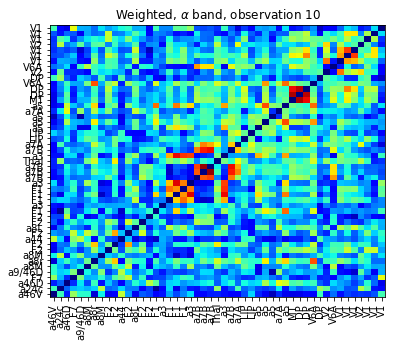

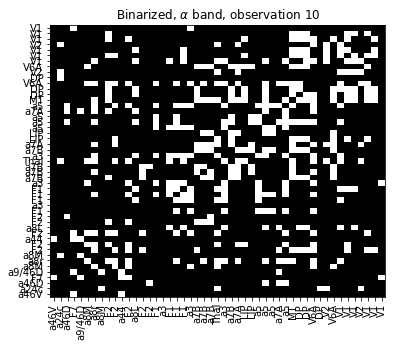

In [23]:
plot_adjacency(net.A[:,:,1,10], net.session_info['areas'], 'jet', (6,5))
plt.title(r'Weighted, $\alpha$ band, observation 10')
plot_adjacency(net.A[:,:,1,10]>net.coh_thr[1], net.session_info['areas'], 'gray', (6,5))
plt.title(r'Binarized, $\alpha$ band, observation 10')

Before moving the measures and preliminary results, during the analysis we may be interested to separate the measures we make by task stage, to do so we need some way to acess our arrays (super_tensor, adjacency matrix, node_degree...) in an specific stage. Using the method __create_stages_time_grid__, four array will be created inside the object: __t_baseline__, __t_cue__, __t_delay__, and __t_match__. Using those array any stage can be acessed easily, let's suposse you want the super tensor values only for the delay period in alpha band, you can retrieve this values by doing:

```net.super_tensor[:,1,net.t_baseline] ```

In [24]:
# Creating stages grid
net.create_stages_time_grid()

Now let's plot for each trial the duration of each period

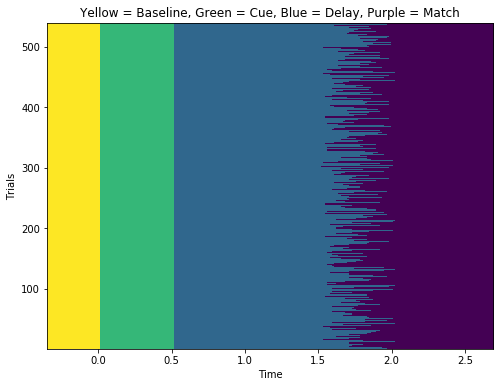

In [25]:
stages = np.zeros([net.session_info['nT'],len(net.tarray)])
ii     = [net.t_baseline.reshape(net.session_info['nT'],len(net.tarray)), 
          net.t_cue.reshape(net.session_info['nT'],len(net.tarray)), 
          net.t_delay.reshape(net.session_info['nT'],len(net.tarray)),
          net.t_match.reshape(net.session_info['nT'],len(net.tarray))]
for i in range(4):
    stages = stages - i * ii[i]
    
plt.figure(figsize = (8,6))
plt.imshow(stages, aspect='auto',cmap='viridis',origin='lower', extent=[net.tarray[0],net.tarray[-1],1,net.session_info['nT']])
plt.ylabel('Trials')
plt.xlabel('Time')
plt.title('Yellow = Baseline, Green = Cue, Blue = Delay, Purple = Match')
plt.savefig('figures/layerwise_net/stages.png')

Similarly to separating the measurements by task stage, we could be insterested in separating them by cue type (i.e., by differenciating the cue presented to the monkey), to create the grid which allows us to acess trials were a specific cue was presented to the monkey the method __create_stim_grid__. This method will create an array named __stim_grid__ inside the __temporal_network__ object, this array will have the shape [Number of cues, Trials * Time]. Let's suposse you want the super tensor values in the alpha band only for the second cue type presented, you can retrieve this values by doing:

```net.super_tensor[:,1,net.stim_grid[1]] ```

In [26]:
net.create_stim_grid()

We can now visualize, for instance, which trials received each cue type (for the first 20 trials):

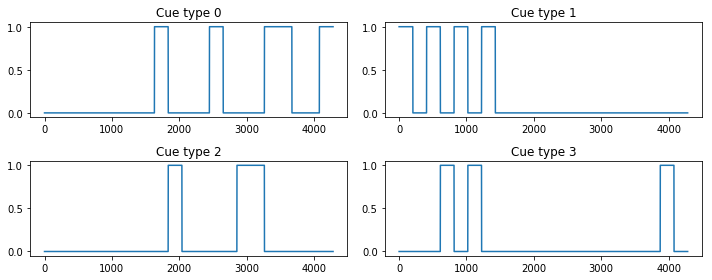

In [27]:
plt.figure(figsize=(10,4))
for i in range(net.stim_grid.shape[0]-1):
    plt.subplot(2,2,i+1)
    plt.plot(net.stim_grid[i,:21*len(net.tarray)])
    plt.title('Cue type ' + str(i))
plt.tight_layout()

In [ ]:
# Values of q used
q_list     = np.linspace(0.2, 0.9, 10)
n_retained = np.zeros([len(q_list), len(net.bands), 4]) # [Values of q, Number of bands, Number of stages]
# Computing the threshold for the specific q value
for i in tqdm( range( len( q_list) ) ):
    net.compute_coherence_thresholds(q = q_list[i])
    for j in range( len(net.bands) ):
        # Binary super tensor
        bst               = net.super_tensor[:,j,:] > net.coh_thr[j]
        n_retained[i,j,0] = bst[:,net.t_baseline].sum() / (net.session_info['nP'] * net.t_baseline.sum())
        n_retained[i,j,1] = bst[:,net.t_cue].sum()      / (net.session_info['nP'] * net.t_cue.sum())
        n_retained[i,j,2] = bst[:,net.t_delay].sum()    / (net.session_info['nP'] * net.t_delay.sum())
        n_retained[i,j,3] = bst[:,net.t_match].sum()    / (net.session_info['nP'] * net.t_match.sum())

# Set q to 0.80 again
net.compute_coherence_thresholds(q=.8)

In [ ]:
plt.figure(figsize=(12,8))
for j in range( len(net.bands) ):
    plt.subplot(2,2,j+1)
    plt.semilogy(q_list, n_retained[:,j,0], label = 'Baseline')
    plt.semilogy(q_list, n_retained[:,j,1], label = 'Cue')
    plt.semilogy(q_list, n_retained[:,j,2], label = 'Delay')
    plt.semilogy(q_list, n_retained[:,j,3], label = 'Match')
    plt.title(bands[j] + ' band')
    if j == 0:
        plt.legend()
    if j == 2 or j == 3:
        plt.xlabel('q')
    if j == 0 or j == 2:
        plt.ylabel('Fraction of retained links')
plt.savefig('figures/layerwise_net/fraction_reained_links.png')

### Analysing the dependece of coherence distributions on frequency, stage, and cue of link weights 

In [ ]:
plot_pooled_coherence_dists_per_stage(net.super_tensor, 
                                      [net.t_baseline, net.t_cue, net.t_delay, net.t_match],
                                      bins = 100, normed = True, titles = bands, figsize=(12,8))
plt.savefig('figures/layerwise_net/pooled_st_dist_per_band.png')

In [ ]:
plot_pooled_coherence_dists_per_stim(net.super_tensor, 
                                      net.stim_grid,
                                      bins = 100, normed = True, titles = bands, figsize=(12,8))
plt.savefig('figures/layerwise_net/pooled_st_dist_per_cue.png')

### Null models and temporal correlations

It is possible to create null models for the adjacency matrix by using the method __create_null_model__, it i possible to create a null model by randomizing the edges by setting the parameter __randomize='edges'__, or by permuting the time layers by setting __randomize='time'__. The adjacency matrix for the null model is stored on the variable __A_null__. After creating the null models we can compare, for instance, compute the temporal correlation of the adjacency matrices for the original network and the randomized ones using the function __compute_temporal_correlation__.

In [ ]:
CC_re = np.zeros(10) # Randomized edges
CC_rt = np.zeros(10) # Randomized layers
# Original network
CC_on = net.compute_temporal_correlation(band = 1, thr = net.coh_thr[1], tau = 1, on_null = False)
for i in tqdm( range(10) ):
    # Randomize on edges
    CC_re[i] = net.compute_temporal_correlation(band = 1, thr = net.coh_thr[1], tau = 1, 
                                                on_null = True, randomize = 'edges', seed = i)
    # Randomize on time
    CC_rt[i] = net.compute_temporal_correlation(band = 1, thr = net.coh_thr[1], tau = 1, 
                                                on_null = True, randomize='time', seed = i * 10)

In [ ]:
plt.errorbar(1, CC_re.mean(), CC_re.std(), marker='s')
plt.errorbar(3, CC_rt.mean(), CC_rt.std(), marker='s')
plt.hlines(CC_on, 0, 4, linestyle='--', color = 'r')
plt.xlim([0,4])
plt.ylabel('Temporal correlation')
plt.xticks([1,3], ['RE', 'RP'])
plt.savefig('figures/layerwise_net/temp_corr_re_rp.png')

### Node strength/degree

Next we can compute a few network measures in the data, as a general rule if the parameter __thr__ is set to __None__ in those methods the weighted version of the measure will be computed (networkx), and the binarized (networkx or igraph) otherwise. 

Let's start by computing the node strength/degree using the method __compute_nodes_degree__.


__OBSERVATION__: Since computing node strength/degree is straightfoward, once the adjacency matrix are in hand the method __compute_nodes_degree__ does not rely on networkx.

In [28]:
# Computing node strength for each band
st_delta = net.compute_nodes_degree(0, thr = None)
st_alpha = net.compute_nodes_degree(1, thr = None)
st_beta  = net.compute_nodes_degree(2, thr = None)
st_gamma = net.compute_nodes_degree(3, thr = None)
#
st = np.array([st_delta, st_alpha, st_beta, st_gamma])
st = np.swapaxes(st, 0,1)

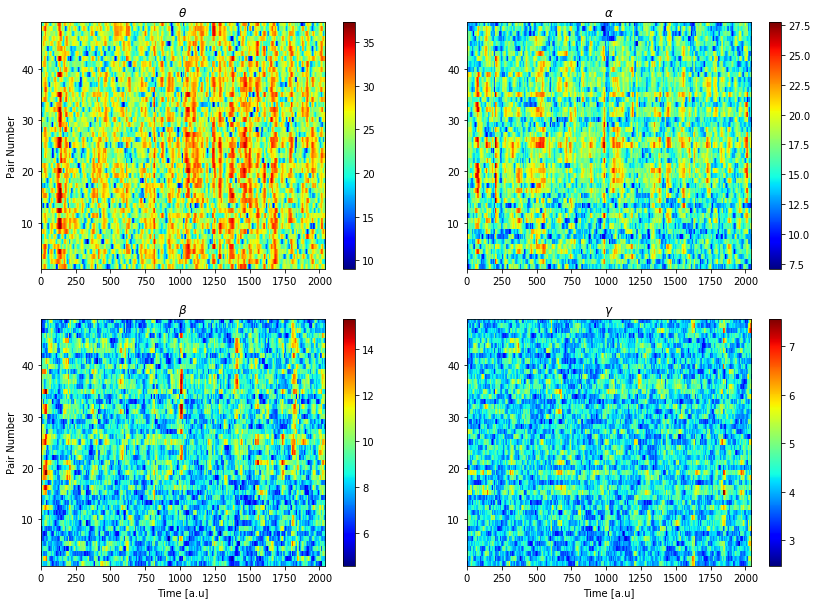

In [29]:
plot_nodes_raster_all_bands(st[:,:,:10*len(net.tarray)], 
                            0, 10*len(net.tarray), 
                            1, net.session_info['nC'], None, None, 
                            'Pair Number', 'Time [a.u]', bands, (14,10), 'jet')
plt.savefig('figures/layerwise_net/raster_strength.png')

In [30]:
# Computing node degree for each band
dg_delta = net.compute_nodes_degree(0, thr = net.coh_thr[0])
dg_alpha = net.compute_nodes_degree(1, thr = net.coh_thr[1])
dg_beta  = net.compute_nodes_degree(2, thr = net.coh_thr[2])
dg_gamma = net.compute_nodes_degree(3, thr = net.coh_thr[3])
#
dg = np.array([dg_delta, dg_alpha, dg_beta, dg_gamma])
dg = np.swapaxes(dg, 0,1)

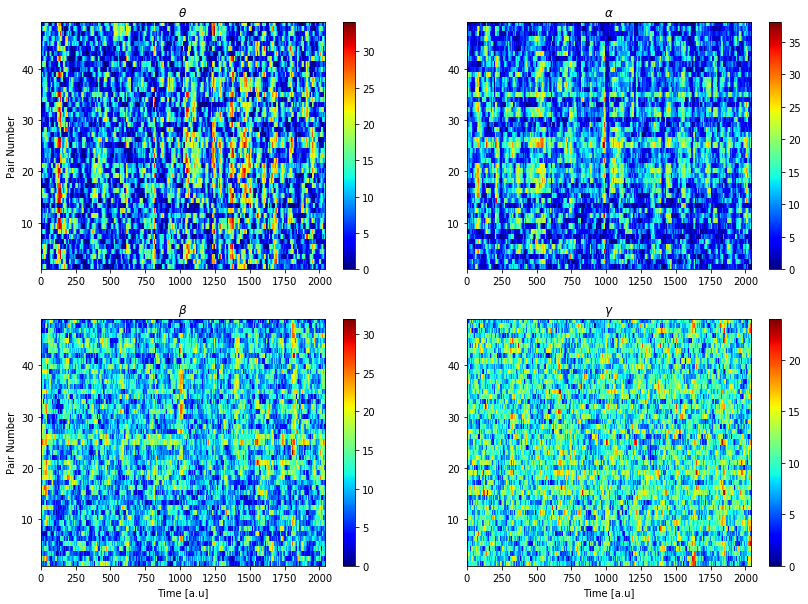

In [31]:
plot_nodes_raster_all_bands(dg[:,:,:10*len(net.tarray)], 
                            0, 10*len(net.tarray), 
                            1, net.session_info['nC'], None, None, 
                            'Pair Number', 'Time [a.u]', bands, (14,10), 'jet')
plt.savefig('figures/layerwise_net/raster_degree.png')

It is hard to compare both the weighted and binary version of the measure by means of the raster plot, however we can measure the summed strength/degree of the network for a more general view. Let's plot the summed node strength/degree for the alpha band, as well as the summed node strength/degree over trials for both weighted (blue plots) and binary (red plots) network.

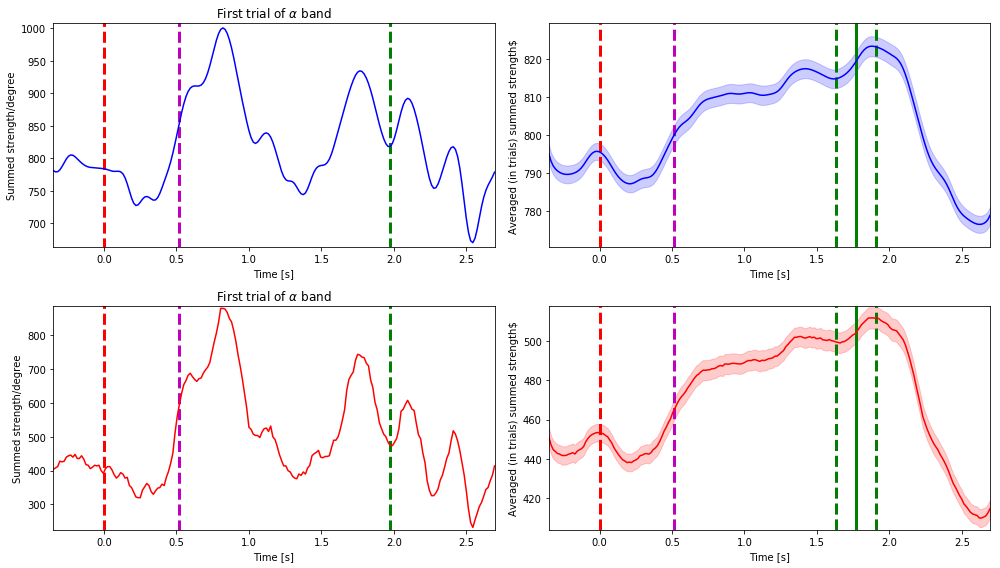

In [32]:
plt.figure(figsize=(14,8))
for i in range(2):
    if i == 0:
        c = 'b'
    else:
        c = 'r'
    p1 = 1 + i*2
    p2 = 2 + i*2
    plt.subplot(2,2,p1)
    if i == 0:
        s_d_w = st_alpha[:,:len(net.tarray)].sum(axis = 0)
    else:
        s_d_w = dg_alpha[:,:len(net.tarray)].sum(axis = 0)
    plt.plot(net.tarray, s_d_w, color = c)
    plt.ylim([s_d_w.min()-7, s_d_w.max()+7])
    plt.xlim([net.tarray[0],net.tarray[-1]])
    plt.vlines(0, s_d_w.min()-10, s_d_w.max()+10, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off'][0]-net.session_info['t_cue_on'][0])/1000, 
               s_d_w.min()-10, s_d_w.max()+10, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on'][0]-net.session_info['t_cue_on'][0])/1000, 
               s_d_w.min()-10, s_d_w.max()+10, linestyle='--', linewidth = 3, color = 'g')
    plt.title(r'First trial of $\alpha$ band')
    plt.xlabel('Time [s]')
    plt.ylabel('Summed strength/degree')
    plt.subplot(2,2,p2)
    if i == 0:
        s_d = st_alpha.sum(axis=0)
    else:
        s_d = dg_alpha.sum(axis=0)
    s_d = s_d.reshape(net.session_info['nT'],len(net.tarray))
    s_d_m = s_d.mean(axis = 0)
    s_d_e = s_d.std(axis = 0) / (s_d.shape[0]**0.5)
    s_d_m = s_d_m
    s_d_e = s_d_e
    plt.plot(net.tarray, s_d_m, color = c)
    plt.fill_between(net.tarray, s_d_m-s_d_e, s_d_m+s_d_e, alpha = .2, color = c)
    plt.xlim([net.tarray[0],net.tarray[-1]])
    plt.ylim([s_d_m.min()-6, s_d_m.max()+6])
    plt.vlines(0, s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
               s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='-', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'g')
    plt.ylabel('Averaged (in trials) summed strength$')
    plt.xlabel('Time [s]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/strength_first_trial.png')

Next, we can analyse the summed strength avareged on trials for each frequency band as well:

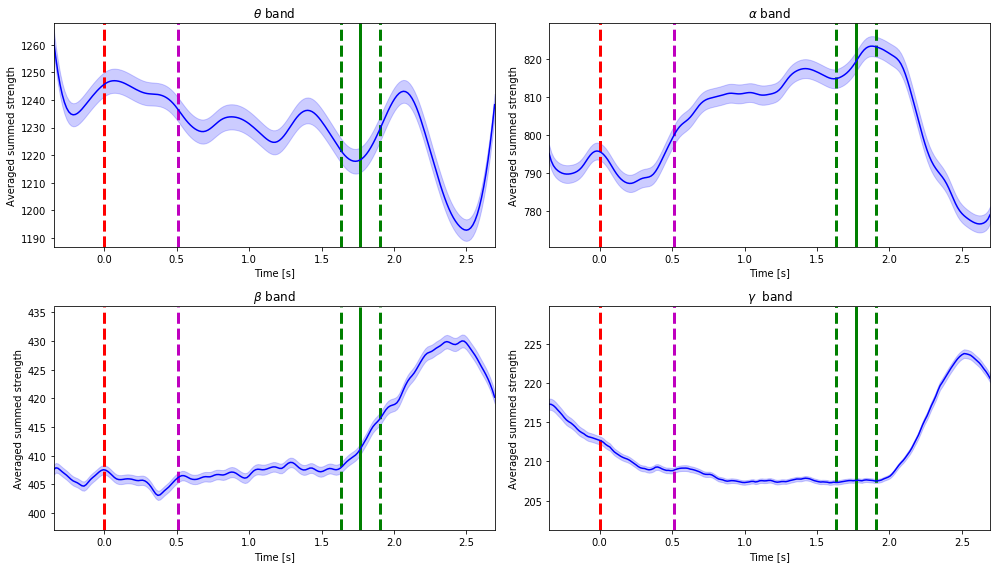

In [33]:
plt.figure(figsize=(14,8))
c = ['b', 'r']
for j in range( len(net.bands) ):
    plt.subplot(2,2,j+1)
    # Original
    s_d = st[:,j,:].sum(axis=0)
    s_d = s_d.reshape(net.session_info['nT'],len(net.tarray))
    s_d_m = s_d.mean(axis = 0)
    s_d_e = s_d.std(axis = 0) / (s_d.shape[0]**0.5)
    #
    plt.plot(net.tarray, s_d_m, color = 'b')
    plt.fill_between(net.tarray, s_d_m-s_d_e, s_d_m+s_d_e, alpha = .2, color = 'b')
    #
    plt.title(bands[j] + ' band')
    plt.xlim([net.tarray[0],net.tarray[-1]])
    plt.ylim([s_d_m.min()-6, s_d_m.max()+6])
    plt.vlines(0, s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                   s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='-', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'g')
    plt.ylabel('Averaged summed strength')
    plt.xlabel('Time [s]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/summed_strength.png')

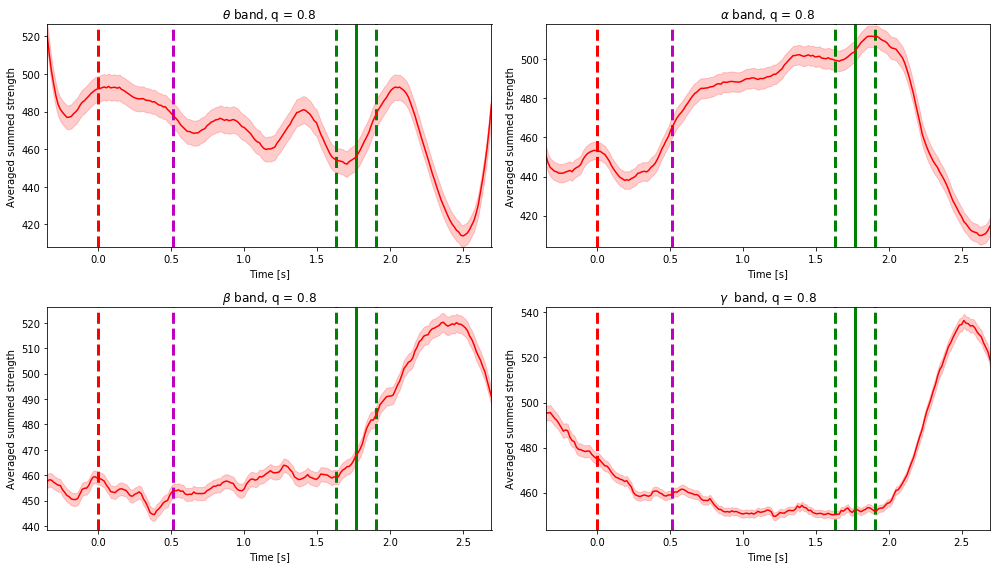

In [34]:
plt.figure(figsize=(14,8))
c = ['b', 'r']
for j in range( len(net.bands) ):
    plt.subplot(2,2,j+1)
    if j == 0: s_d = dg_delta.sum(axis=0)
    if j == 1: s_d = dg_alpha.sum(axis=0)
    if j == 2: s_d = dg_beta.sum(axis=0)
    if j == 3: s_d = dg_gamma.sum(axis=0)
    s_d = s_d.reshape(net.session_info['nT'],len(net.tarray))
    s_d_m = s_d.mean(axis = 0)
    s_d_e = s_d.std(axis = 0) / (s_d.shape[0]**0.5)
    plt.plot(net.tarray, s_d_m, color = 'r')
    plt.fill_between(net.tarray, s_d_m-s_d_e, s_d_m+s_d_e, alpha = .2, color='r')
    plt.title(bands[j] + ' band, q = 0.8')
    plt.xlim([net.tarray[0],net.tarray[-1]])
    plt.ylim([s_d_m.min()-6, s_d_m.max()+6])
    plt.vlines(0, s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                   s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='-', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+8, linestyle='--', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+8, linestyle='--', linewidth = 3, color = 'g')
    plt.ylabel('Averaged summed strength')
    plt.xlabel('Time [s]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/summed_degree.png')

Last but not least, we can instead of average over all trials take the average by trials that the same cue was applied:

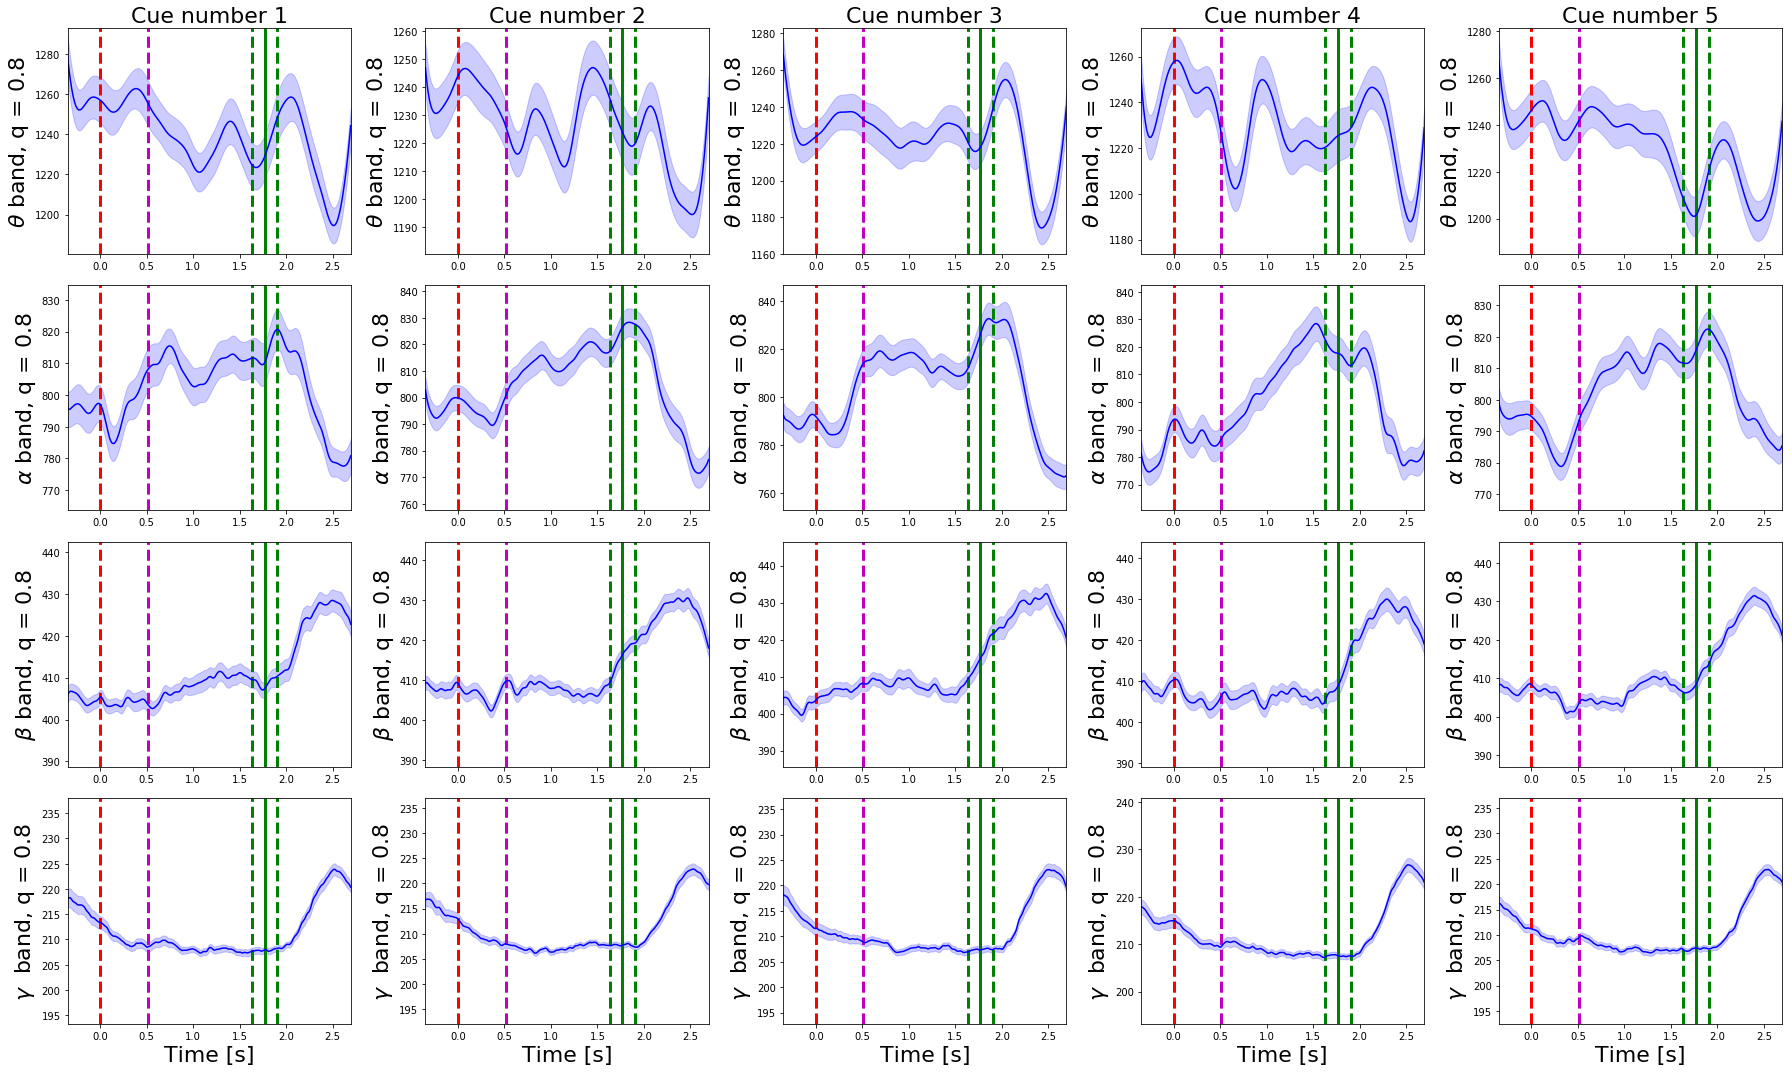

In [35]:
idx = 1
plt.figure(figsize=(25,15))
for i in range( len(net.bands) ):
    for j in range( net.stim_grid.shape[0] ):
        # Computing average over trials for specific cue number
        nt  = np.sum(net.session_info['stim']==j)
        if i == 0: s_d = st_delta.sum(axis=0)
        if i == 1: s_d = st_alpha.sum(axis=0)
        if i == 2: s_d = st_beta.sum(axis=0)
        if i == 3: s_d = st_gamma.sum(axis=0)
        s_d = s_d[net.stim_grid[j].astype(bool)].reshape(nt, len(net.tarray))
        s_d_m = s_d.mean(axis = 0)
        s_d_e = s_d.std(axis = 0) / (s_d.shape[0]**0.5)
        # plot
        plt.subplot( len(net.bands), net.stim_grid.shape[0], idx)
        plt.plot(net.tarray, s_d_m, color = 'b')
        plt.fill_between(net.tarray, s_d_m-s_d_e, s_d_m+s_d_e, alpha = .2, color='b')
        plt.xlim([net.tarray[0],net.tarray[-1]])
        plt.ylim([s_d_m.min()-14, s_d_m.max()+14])
        plt.vlines(0, s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'r')
        plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                   s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'm')
        plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-14, s_d_m.max()+14, linestyle='-', linewidth = 3, color = 'g')
        plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'g')
        plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'g')
        plt.ylabel(bands[i] + ' band, q = 0.8', fontsize=22)
        idx += 1
        if i == 0:
            plt.title('Cue number ' + str(j+1), fontsize=22)
        if i == 3:
            plt.xlabel('Time [s]', fontsize=22)
plt.tight_layout()
plt.savefig('figures/layerwise_net/summed_degree_bands_cue.png')

### Correlation between strength and degree as a function of threshold

In [ ]:
q_list= np.linspace(0.2, 0.9, 10)
cc_ns = np.zeros([len(q_list), len(net.bands) ])
for i in tqdm (range( len(q_list) )):
    net.compute_coherence_thresholds(q = q_list[i])
    for j in range( len(net.bands) ):
        # Degree
        degree   = net.compute_nodes_degree(j, thr = net.coh_thr[j]).sum(axis = 0)
        # Strength
        strength = net.compute_nodes_degree(j, thr = None).sum(axis = 0)
        # Correlation
        cc_ns[i,j] = np.corrcoef(strength, degree)[0,1]

In [ ]:
plt.figure(figsize=(8,6))
for j in range( len(net.bands) ):
    plt.plot(q_list, cc_ns[:,j], label = bands[j] + ' band')
    plt.ylabel('CC(strength, degree)')
    plt.xlabel('q')
plt.xlim([0.2,0.9])
plt.hlines(0.90,0.2,0.9, linestyle = '--', color = 'k')
plt.legend()
plt.savefig('figures/layerwise_net/cc_st_dg.png')

In [ ]:
# Put threshold back to q = 0.8
net.compute_coherence_thresholds(q = 0.8)

### Randomized networks preserving degree

To create the random network the method __create_null_model__, it will create a randomized version of the adjacency matrix A in a given band seted by the parameter __band__, the parameter __randomize__ can be set either as __edges__ or __time__, in the first case the edges for each node will be randomized for each layer, in the latter the frames of the temporal netowork will be randomly shuffled, you can also set the randomization seed using the parameter __seed__. 

You can compute the network quantities in the null model by setting the parameter __on_null__ equals __True__ in the method for each measurement. Let's plot the degree of the randomized vs. the original network for each band (without error bars for better visualization).


In [36]:
st_random = np.zeros([net.A.shape[0], len(net.bands),  net.A.shape[-1]])
for i in [1]:#tqdm( range(len(net.bands)) ):
    st_random[:,i,:] = net.compute_nodes_degree(band = i, thr = net.coh_thr[i], 
                                                on_null = True, randomize='edges', seed = 0)

A threshold value should be provided


In [ ]:
plt.figure(figsize=(14,8))
for j in range( len(net.bands) ):
    plt.subplot(2,2,j+1)
    # Original
    s_d = dg[:,j,:].sum(axis=0)
    s_d = s_d.reshape(net.session_info['nT'],len(net.tarray))
    s_d_m = s_d.mean(axis = 0)
    #
    plt.plot(net.tarray, s_d_m, 'b', lw=5)
    # Random
    s_d = st_random[:,j,:].sum(axis=0)
    s_d = s_d.reshape(net.session_info['nT'],len(net.tarray))
    s_d_m = s_d.mean(axis = 0)
    #
    plt.plot(net.tarray, s_d_m, 'm--', lw=5)
    if j == 0:
        plt.legend(['Original', 'Randomized'])
    plt.title(bands[j] + ' band')
    plt.xlim([net.tarray[0],net.tarray[-1]])
    plt.ylim([s_d_m.min()-6, s_d_m.max()+6])
    plt.vlines(0, s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                   s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='-', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'g')
    plt.ylabel('Averaged summed degree')
    plt.xlabel('Time [s]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/strength_random_edges.png')

To compute a given network statistics for more than one randomization, the method __net.compute_null_statistics__ can be used. It takes as arguments the name of the method relative to the desired statistics (e.g., __net.compute_nodes_degrees__), the number of different randomizations to take into consideration __n_stat__, and the parameters that shoudl be passes to the method given as first argument.

### Coreness 

The analysis below are all done for the binary network. First, we can do the same analysis measuring the k-coreness of the each node:

In [ ]:
kc_delta = net.compute_nodes_coreness(band=0, thr=net.coh_thr[0], use='igraph')
kc_alpha = net.compute_nodes_coreness(band=1, thr=net.coh_thr[1], use='igraph')
kc_beta  = net.compute_nodes_coreness(band=2, thr=net.coh_thr[2], use='igraph')
kc_gamma = net.compute_nodes_coreness(band=3, thr=net.coh_thr[3], use='igraph')

kc = np.array([kc_delta, kc_alpha, kc_beta, kc_gamma])
kc = np.swapaxes(kc, 0,1)

In [ ]:
plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plt.imshow(kc_delta[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks(range(net.session_info['nC']), net.session_info['areas'])
plt.title(r'$\theta$  band')
plt.subplot(2,2,2)
plt.imshow(kc_alpha[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks([])
plt.title(r'$\alpha$  band')
plt.subplot(2,2,3)
plt.imshow(kc_beta[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks(range(net.session_info['nC']), net.session_info['areas'])
plt.title(r'$\beta$  band')
plt.xlabel('Time [u.a]')
plt.subplot(2,2,4)
plt.imshow(kc_gamma[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks([])
plt.title(r'$\gamma$  band')
plt.xlabel('Time [u.a]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/raster_coreness.png')

In [ ]:
plt.figure(figsize=(14,8))
for j in range( len(net.bands) ):
    plt.subplot(2,2,j+1)
    if j == 0: s_d = kc_delta.sum(axis=0)
    if j == 1: s_d = kc_alpha.sum(axis=0)
    if j == 2: s_d = kc_beta.sum(axis=0)
    if j == 3: s_d = kc_gamma.sum(axis=0)
    #s_d = net.coreness[1,:,j,:].sum(axis=0)
    s_d = s_d.reshape(net.session_info['nT'],len(net.tarray))
    s_d_m = s_d.mean(axis = 0)
    s_d_e = s_d.std(axis = 0) / (s_d.shape[0]**0.5)
    plt.plot(net.tarray, s_d_m, color = 'b')
    plt.fill_between(net.tarray, s_d_m-s_d_e, s_d_m+s_d_e, color = 'b', alpha = .2)
    plt.title(bands[j] + ' band, q = 0.8')
    plt.xlim([net.tarray[0],net.tarray[-1]])
    plt.ylim([s_d_m.min()-6, s_d_m.max()+6])
    plt.vlines(0, s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='-', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+8, linestyle='--', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+8, linestyle='--', linewidth = 3, color = 'g')
    plt.ylabel('Averaged coreness')
    plt.xlabel('Time [s]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/summed_coreness.png')

In [ ]:
idx = 1
plt.figure(figsize=(25,15))
for i in range( len(net.bands) ):
    for j in range( net.stim_grid.shape[0] ):
        # Computing average over trials for specific cue number
        nt  = np.sum(net.session_info['stim']==j)
        if i == 0: s_d = kc_delta.sum(axis=0)
        if i == 1: s_d = kc_alpha.sum(axis=0)
        if i == 2: s_d = kc_beta.sum(axis=0)
        if i == 3: s_d = kc_gamma.sum(axis=0)
        #s_d = net.coreness[1,:,i,:].sum(axis=0)
        s_d = s_d[net.stim_grid[j].astype(bool)].reshape(nt, len(net.tarray))
        s_d_m = s_d.mean(axis = 0)
        s_d_e = s_d.std(axis = 0) / (s_d.shape[0]**0.5)
        # plot
        plt.subplot( len(net.bands), net.stim_grid.shape[0], idx)
        plt.plot(net.tarray, s_d_m, color = 'b')
        plt.fill_between(net.tarray, s_d_m-s_d_e, s_d_m+s_d_e, color = 'b', alpha = .2)
        plt.xlim([net.tarray[0],net.tarray[-1]])
        plt.ylim([s_d_m.min()-14, s_d_m.max()+14])
        plt.vlines(0, s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'r')
        plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                   s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'm')
        plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-14, s_d_m.max()+14, linestyle='-', linewidth = 3, color = 'g')
        plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'g')
        plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'g')
        plt.ylabel(bands[i] + ' band, q = 0.8', fontsize=22)
        idx += 1
        if i == 0:
            plt.title('Cue number ' + str(j+1), fontsize=22)
        if i == 3:
            plt.xlabel('Time [s]', fontsize=22)
plt.tight_layout()
plt.savefig('figures/layerwise_net/summed_coreness_bands_cue.png')

### Coreness - Chance level (alpha band)

In [ ]:
start   = time.time()
kc_null = net.compute_null_statistics(net.compute_nodes_coreness, 10, band = 1, thr = net.coh_thr[1], 
                                      use='igraph', randomize = 'edges', 
                                      seed = 10, n_jobs=5)
end   = time.time()
print('Exc. time = ' + str((end-start)/60) + ' min.')

In [ ]:
plt.figure(figsize=(8,6))
kc_null = np.array(kc_null)
# null model 
kc_nl = net.reshape_trials(kc_null).mean(axis=0).sum(axis=0)
# Original
kc_or = net.reshape_trials(kc_alpha).sum(axis=0) 
# Excess
E  = (kc_or - kc_nl) / kc_nl 
Em = E.mean(axis=0)
Es = 2*E.std(axis = 0) / np.sqrt(E.shape[0])
# Plot
plt.plot(net.tarray, Em)
plt.fill_between(net.tarray, Em-Es, Em+Es, alpha = .4)
plt.ylim([Em.min()-.005, Em.max()+.005])
plt.xlim([net.tarray[0], net.tarray[-1]])
plt.vlines(0, Em.min()-14, Em.max()+14, linestyle='--', linewidth = 3, color = 'r')
plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                   Em.min()-14, Em.max()+14, linestyle='--', linewidth = 3, color = 'm')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       Em.min()-14, Em.max()+14, linestyle='-', linewidth = 3, color = 'g')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       Em.min()-14, Em.max()+14, linestyle='--', linewidth = 3, color = 'g')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       Em.min()-14, Em.max()+14, linestyle='--', linewidth = 3, color = 'g')
plt.xlabel('Time [ms]')
plt.ylabel(r'Coreness')
plt.title(r'$\alpha$ band')
plt.savefig('figures/layerwise_net/excess_coreness.png')

### Clustering

Next we compute the clustering coefficient.

In [ ]:
cl_delta = net.compute_nodes_clustering(band=0, thr=net.coh_thr[0], use='igraph')
cl_alpha = net.compute_nodes_clustering(band=1, thr=net.coh_thr[1], use='igraph')
cl_beta  = net.compute_nodes_clustering(band=2, thr=net.coh_thr[2], use='igraph')
cl_gamma = net.compute_nodes_clustering(band=3, thr=net.coh_thr[3], use='igraph')

cl = np.array([cl_delta, cl_alpha, cl_beta, cl_gamma])
cl = np.swapaxes(cl, 0,1)

In [ ]:
plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plt.imshow(cl_delta[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks(range(net.session_info['nC']), net.session_info['areas'])
plt.title(r'$\theta$  band')
plt.subplot(2,2,2)
plt.imshow(cl_alpha[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks([])
plt.title(r'$\alpha$  band')
plt.subplot(2,2,3)
plt.imshow(cl_beta[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks(range(net.session_info['nC']), net.session_info['areas'])
plt.title(r'$\beta$  band')
plt.xlabel('Time [u.a]')
plt.subplot(2,2,4)
plt.imshow(cl_gamma[:,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.yticks([])
plt.title(r'$\gamma$  band')
plt.xlabel('Time [u.a]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/raster_clustering.png')

In [ ]:
plt.figure(figsize=(14,8))
for j in range( len(net.bands) ):
    plt.subplot(2,2,j+1)
    if j == 0: s_d = np.nan_to_num(cl_delta).sum(axis=0)
    if j == 1: s_d = np.nan_to_num(cl_alpha).sum(axis=0)
    if j == 2: s_d = np.nan_to_num(cl_beta).sum(axis=0)
    if j == 3: s_d = np.nan_to_num(cl_gamma).sum(axis=0)
    #s_d = net.coreness[1,:,j,:].sum(axis=0)
    s_d = s_d.reshape(net.session_info['nT'],len(net.tarray))
    s_d_m = s_d.mean(axis = 0)
    s_d_e = s_d.std(axis = 0) / (s_d.shape[0]**0.5)
    plt.plot(net.tarray, s_d_m, color = 'b')
    plt.fill_between(net.tarray, s_d_m-s_d_e, s_d_m+s_d_e, color = 'b', alpha = .2)
    plt.title(bands[j] + ' band, q = 0.8')
    plt.xlim([net.tarray[0],net.tarray[-1]])
    plt.ylim([s_d_m.min()-0.5, s_d_m.max()+.5])
    plt.vlines(0, s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='-', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+8, linestyle='--', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+8, linestyle='--', linewidth = 3, color = 'g')
    plt.ylabel('Averaged coreness')
    plt.xlabel('Time [s]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/summed_clustering.png')

In [ ]:
idx = 1
plt.figure(figsize=(25,15))
for i in range( len(net.bands) ):
    for j in range( net.stim_grid.shape[0] ):
        # Computing average over trials for specific cue number
        nt  = np.sum(net.session_info['stim']==j)
        if i == 0: s_d = np.nan_to_num(cl_delta).sum(axis=0)
        if i == 1: s_d = np.nan_to_num(cl_alpha).sum(axis=0)
        if i == 2: s_d = np.nan_to_num(cl_beta).sum(axis=0)
        if i == 3: s_d = np.nan_to_num(cl_gamma).sum(axis=0)
        #s_d = net.coreness[1,:,i,:].sum(axis=0)
        s_d = s_d[net.stim_grid[j].astype(bool)].reshape(nt, len(net.tarray))
        s_d_m = s_d.mean(axis = 0)
        s_d_e = s_d.std(axis = 0) / (s_d.shape[0]**0.5)
        # plot
        plt.subplot( len(net.bands), net.stim_grid.shape[0], idx)
        plt.plot(net.tarray, s_d_m, color = 'b')
        plt.fill_between(net.tarray, s_d_m-s_d_e, s_d_m+s_d_e, color = 'b', alpha = .2)
        plt.xlim([net.tarray[0],net.tarray[-1]])
        plt.ylim([s_d_m.min()-.5, s_d_m.max()+.5])
        plt.vlines(0, s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'r')
        plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                   s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'm')
        plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-14, s_d_m.max()+14, linestyle='-', linewidth = 3, color = 'g')
        plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'g')
        plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-14, s_d_m.max()+14, linestyle='--', linewidth = 3, color = 'g')
        plt.ylabel(bands[i] + ' band, q = 0.8', fontsize=22)
        idx += 1
        if i == 0:
            plt.title('Cue number ' + str(j+1), fontsize=22)
        if i == 3:
            plt.xlabel('Time [s]', fontsize=22)
plt.tight_layout()
plt.savefig('figures/layerwise_net/summed_clustering_bands_cue.png')

### Clustering - chance level (alpha)

In [ ]:
start   = time.time()
cl_null = net.compute_null_statistics(net.compute_nodes_clustering, 10, band = 1, thr = net.coh_thr[1], 
                                      use='igraph', randomize = 'edges', 
                                      seed = 10, n_jobs=5)
end   = time.time()
print('Exc. time = ' + str((end-start)/60) + ' min.')

In [ ]:
plt.figure(figsize=(8,6))
cl_null = np.array(cl_null)
# null model 
cl_nl = net.reshape_trials(cl_null).mean(axis=0).sum(axis=0)
# Original
cl_or = net.reshape_trials(cl_alpha).sum(axis=0) 
# Excess
E  = (cl_or - cl_nl) / cl_nl 
Em = E.mean(axis=0)
Es = 2*E.std(axis = 0) / np.sqrt(E.shape[0])
# Plot
plt.plot(net.tarray, Em)
plt.fill_between(net.tarray, Em-Es, Em+Es, alpha = .4)
plt.ylim([Em.min()-.03, Em.max()+.03])
plt.xlim([net.tarray[0], net.tarray[-1]])
plt.vlines(0, Em.min()-14, Em.max()+14, linestyle='--', linewidth = 3, color = 'r')
plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                   Em.min()-14, Em.max()+14, linestyle='--', linewidth = 3, color = 'm')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       Em.min()-14, Em.max()+14, linestyle='-', linewidth = 3, color = 'g')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       Em.min()-14, Em.max()+14, linestyle='--', linewidth = 3, color = 'g')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       Em.min()-14, Em.max()+14, linestyle='--', linewidth = 3, color = 'g')
plt.xlabel('Time [ms]')
plt.ylabel(r'Clustering')
plt.title(r'$\alpha$ band')
plt.savefig('figures/layerwise_net/excess_clustering.png')

### Modularity

In [ ]:
# Original net
m_delta = net.compute_network_modularity(band=0, thr=net.coh_thr[0], use='igraph', on_null=False)
m_alpha = net.compute_network_modularity(band=1, thr=net.coh_thr[1], use='igraph', on_null=False)
m_beta  = net.compute_network_modularity(band=2, thr=net.coh_thr[2], use='igraph', on_null=False)
m_gamma = net.compute_network_modularity(band=3, thr=net.coh_thr[3], use='igraph', on_null=False)

In [ ]:
plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plt.imshow(m_delta.reshape([net.session_info['nT'], len(net.tarray)]), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[net.tarray[0], net.tarray[-1], 1, 540]); plt.colorbar()
plt.ylabel('Trials')
plt.title(r'$\theta$  band')
plt.subplot(2,2,2)
plt.imshow(m_alpha.reshape([net.session_info['nT'], len(net.tarray)]), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[net.tarray[0], net.tarray[-1], 1, 540]); plt.colorbar()
plt.yticks([])
plt.title(r'$\alpha$  band')
plt.subplot(2,2,3)
plt.imshow(m_beta.reshape([net.session_info['nT'], len(net.tarray)]), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[net.tarray[0], net.tarray[-1], 1, 540]); plt.colorbar()
plt.title(r'$\beta$  band')
plt.ylabel('Trials')
plt.xlabel('Time [s]')
plt.subplot(2,2,4)
plt.imshow(m_gamma.reshape([net.session_info['nT'], len(net.tarray)]), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[net.tarray[0], net.tarray[-1], 1, 540]); plt.colorbar()
plt.yticks([])
plt.title(r'$\gamma$  band')
plt.xlabel('Time [s]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/raster_modularity.png')

In [ ]:
plt.figure(figsize=(14,8))
for j in range( len(net.bands) ):
    plt.subplot(2,2,j+1)
    if j == 0: s_d = m_delta
    if j == 1: s_d = m_alpha
    if j == 2: s_d = m_beta
    if j == 3: s_d = m_gamma
    #s_d = net.coreness[1,:,j,:].sum(axis=0)
    s_d = s_d.reshape(net.session_info['nT'],len(net.tarray))
    s_d_m = s_d.mean(axis = 0)
    s_d_e = s_d.std(axis = 0) / (s_d.shape[0]**0.5)
    plt.plot(net.tarray, s_d_m, color = 'b')
    plt.fill_between(net.tarray, s_d_m-s_d_e, s_d_m+s_d_e, color = 'b', alpha = .2)
    plt.title(bands[j] + ' band, q = 0.8')
    plt.xlim([net.tarray[0],net.tarray[-1]])
    plt.ylim([s_d_m.min()-0.01, s_d_m.max()+.01])
    plt.vlines(0, s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='-', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+8, linestyle='--', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+8, linestyle='--', linewidth = 3, color = 'g')
    plt.ylabel('Averaged modularity')
    plt.xlabel('Time [s]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/summed_modularity.png')

In [ ]:
plt.figure(figsize=(14,10))
for j in range( len(net.bands) ):
    plt.subplot(2,2,j+1)
    if j == 0: s_d = m_delta
    if j == 1: s_d = m_alpha
    if j == 2: s_d = m_beta
    if j == 3: s_d = m_gamma
    for i in range(net.stim_grid.shape[0]):
        nt  = np.sum(net.session_info['stim']==i)
        s_d_aux = s_d[net.stim_grid[i].astype(bool)].copy()
        s_d_aux = s_d_aux.reshape(nt,len(net.tarray))
        s_d_m = s_d_aux.mean(axis = 0)
        s_d_e = s_d_aux.std(axis = 0) / (s_d.shape[0]**0.5)
        plt.plot(net.tarray, s_d_m)
        plt.fill_between(net.tarray, s_d_m-s_d_e, s_d_m+s_d_e, alpha = .2)
    plt.title(bands[j] + ' band, q = 0.8')
    plt.xlim([net.tarray[0],net.tarray[-1]])
    plt.ylim([s_d_m.min()-0.02, s_d_m.max()+.01])
    plt.vlines(0, s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       s_d_m.min()-6, s_d_m.max()+6, linestyle='-', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+8, linestyle='--', linewidth = 3, color = 'g')
    plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       s_d_m.min()-6, s_d_m.max()+8, linestyle='--', linewidth = 3, color = 'g')
    if j == 0:
        plt.legend(['Stim. 1', 'Stim. 2', 'Stim. 3', 'Stim. 4', 'Stim. 5'])
    plt.ylabel('Averaged modularity')
    plt.xlabel('Time [s]')
plt.tight_layout()
plt.savefig('figures/layerwise_net/modularity_cues.png')

### Modularity - chance level (alpha)

In [ ]:
start   = time.time()
m_null = net.compute_null_statistics(net.compute_network_modularity, 10, band = 1, thr = net.coh_thr[1], 
                                      use='igraph', randomize = 'edges', 
                                      seed = 1, n_jobs=5)
end   = time.time()
print('Exc. time = ' + str((end-start)/60) + ' min.')

In [ ]:
plt.figure(figsize=(8,6))
m_null = np.array(m_null)
# null model 
m_nl = net.reshape_trials(m_null).mean(axis=0)
# Original
m_or = net.reshape_trials(m_alpha)
# Excess
E  = (m_or - m_nl) / m_nl 
Em = E.mean(axis=0)
Es = 2*E.std(axis = 0) / np.sqrt(E.shape[0])
# Plot
plt.plot(net.tarray, Em)
plt.fill_between(net.tarray, Em-Es, Em+Es, alpha = .4)
plt.ylim([Em.min()-.03, Em.max()+.03])
plt.xlim([net.tarray[0], net.tarray[-1]])
plt.vlines(0, Em.min()-14, Em.max()+14, linestyle='--', linewidth = 3, color = 'r')
plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
                   Em.min()-14, Em.max()+14, linestyle='--', linewidth = 3, color = 'm')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
                       Em.min()-14, Em.max()+14, linestyle='-', linewidth = 3, color = 'g')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000-(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       Em.min()-14, Em.max()+14, linestyle='--', linewidth = 3, color = 'g')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000+(net.session_info['t_match_on']-net.session_info['t_cue_on']).std()/1000, 
                       Em.min()-14, Em.max()+14, linestyle='--', linewidth = 3, color = 'g')
plt.xlabel('Time [ms]')
plt.ylabel(r'Modularity')
plt.title(r'$\alpha$ band')
plt.savefig('figures/layerwise_net/excess_modularity.png')

### Allegiance  matrix (theta band)

In order to compute the allegiance matrix we first have to compute the layerwise community labes of each node in order to verity how often they fall in the same module, the allegiance matrix can be computed by using the method __compute_allegiance_matrix__. If the parameter __per_task_stage__ is set to true the allegiance matrix will be computed separately for each stage.

In [ ]:
T = net.compute_allegiance_matrix(band=0, thr=net.coh_thr[0], use='igraph', per_task_stage=True)

In [ ]:
title = ['Baseline', 'Cue-Baseline', 'Delay-Baseline', 'Match-Baseline']
plt.figure(figsize=(12,10))
for k in range(4):
    plt.subplot(2,2,k+1)
    if k > 0:
        plt.imshow((T[k]-T[0])/T[0], aspect = 'auto', cmap = 'jet', origin = 'lower', vmin=-.3, vmax=.3)
    else:
        plt.imshow(T[k], aspect = 'auto', cmap = 'jet', origin = 'lower', vmin = 0, vmax = 1)
    plt.colorbar()
    plt.xticks(range(net.session_info['nC']), net.session_info['areas'], rotation = 90)
    plt.yticks(range(net.session_info['nC']), net.session_info['areas'])
    plt.title(title[k])
plt.tight_layout()
plt.savefig('figures/layerwise_net/allegiance_theta.png')

### Allegiance  matrix (alpha band)

In [ ]:
T = net.compute_allegiance_matrix(band=1, thr=net.coh_thr[1], use='igraph', per_task_stage=True)

In [ ]:
title = ['Baseline', 'Cue-Baseline', 'Delay-Baseline', 'Match-Baseline']
plt.figure(figsize=(12,10))
for k in range(4):
    plt.subplot(2,2,k+1)
    if k > 0:
        plt.imshow((T[k]-T[0])/T[0], aspect = 'auto', cmap = 'jet', origin = 'lower', vmin = -.3, vmax = .3)
    else:
        plt.imshow(T[k], aspect = 'auto', cmap = 'jet', origin = 'lower', vmin = 0, vmax = 1)
    plt.colorbar()
    plt.xticks(range(net.session_info['nC']), net.session_info['areas'], rotation = 90)
    plt.yticks(range(net.session_info['nC']), net.session_info['areas'])
    plt.title(title[k])
plt.tight_layout()
plt.savefig('figures/layerwise_net/allegiance_alpha.png')

### Allegiance  matrix (beta band)

In [ ]:
T = net.compute_allegiance_matrix(band=2, thr=net.coh_thr[2], use='igraph', per_task_stage=True)

In [ ]:
title = ['Baseline', 'Cue-Baseline', 'Delay-Baseline', 'Match-Baseline']
plt.figure(figsize=(12,10))
for k in range(4):
    plt.subplot(2,2,k+1)
    if k > 0:
        plt.imshow((T[k]-T[0])/T[0], aspect = 'auto', cmap = 'jet', origin = 'lower', vmin = -.3, vmax = .3)
    else:
        plt.imshow(T[k], aspect = 'auto', cmap = 'jet', origin = 'lower', vmin = 0, vmax = 1)
    plt.colorbar()
    plt.xticks(range(net.session_info['nC']), net.session_info['areas'], rotation = 90)
    plt.yticks(range(net.session_info['nC']), net.session_info['areas'])
    plt.title(title[k])
plt.tight_layout()
plt.savefig('figures/layerwise_net/allegiance_beta.png')

### Allegiance  matrix (gamma band)

In [ ]:
T = net.compute_allegiance_matrix(band=3, thr=net.coh_thr[3], use='igraph', per_task_stage=True)

In [ ]:
title = ['Baseline', 'Cue-Baseline', 'Delay-Baseline', 'Match-Baseline']
plt.figure(figsize=(12,10))
for k in range(4):
    plt.subplot(2,2,k+1)
    if k > 0:
        plt.imshow((T[k]-T[0])/T[0], aspect = 'auto', cmap = 'jet', origin = 'lower', vmin = -.3, vmax = .3)
    else:
        plt.imshow(T[k], aspect = 'auto', cmap = 'jet', origin = 'lower', vmin = 0, vmax = 1)
    plt.colorbar()
    plt.xticks(range(net.session_info['nC']), net.session_info['areas'], rotation = 90)
    plt.yticks(range(net.session_info['nC']), net.session_info['areas'])
    plt.title(title[k])
plt.tight_layout()
plt.savefig('figures/layerwise_net/allegiance_gamma.png')

### Plotting on the brain surface

Plotting some of the quantities we measured above in the brain surface.

In [ ]:
from GDa.graphics.plot_brain_sketch import plot_node_brain_sketch, plot_edge_brain_sketch

#### Plotting average strength 

In [ ]:
count = 1
alpha = 10
beta  = 1
plt.figure(figsize=(14,8))
for i in range( len(net.bands) ):
    plt.subplot(4, 4, count)
    # Baseline
    st_b = st[:,i,net.t_baseline].mean(axis=1)
    st_b = (st_b - st_b.mean())/st_b.std()
    plot_node_brain_sketch(net.session_info['channels_labels'].astype(int), st_b, alpha, beta, 'viridis')
    count += 1
    plt.ylabel(bands[i] + ' band')
    if i == 0: plt.title('Baseline')
    # Cue
    plt.subplot(4, 4, count)
    st_c = st[:,i,net.t_cue].mean(axis=1)
    st_c = (st_c - st_c.mean())/st_c.std()
    plot_node_brain_sketch(net.session_info['channels_labels'].astype(int), st_c, alpha, beta,  'viridis')
    count += 1
    if i == 0: plt.title('Cue')
    # Delay
    plt.subplot(4, 4, count)
    st_d = st[:,i,net.t_delay].mean(axis=1)
    st_d = (st_d - st_d.mean())/st_d.std()
    plot_node_brain_sketch(net.session_info['channels_labels'].astype(int), st_d, alpha, beta,  'viridis')
    count += 1
    if i == 0: plt.title('Delay')
    # Match
    plt.subplot(4, 4, count)
    st_m = st[:,i,net.t_match].mean(axis=1)
    st_m = (st_m - st_m.mean())/st_m.std()
    plot_node_brain_sketch(net.session_info['channels_labels'].astype(int), st_m, alpha, beta,  'viridis')
    count += 1
    if i == 0: plt.title('Match')
plt.savefig('figures/layerwise_net/st_brain_map.png')

#### Plotting average coreness 

In [ ]:
count = 1
alpha = 10
beta  = 1
plt.figure(figsize=(14,8))
for i in range( len(net.bands) ):
    plt.subplot(4, 4, count)
    # Baseline
    st_b = kc[:,i,net.t_baseline].mean(axis=1)
    st_b = (st_b - st_b.mean())/st_b.std()
    plot_node_brain_sketch(net.session_info['channels_labels'].astype(int), st_b, alpha, beta, 'viridis')
    count += 1
    plt.ylabel(bands[i] + ' band')
    if i == 0: plt.title('Baseline')
    # Cue
    plt.subplot(4, 4, count)
    st_c = kc[:,i,net.t_cue].mean(axis=1)
    st_c = (st_c - st_c.mean())/st_c.std()
    plot_node_brain_sketch(net.session_info['channels_labels'].astype(int), st_c, alpha, beta,  'viridis')
    count += 1
    if i == 0: plt.title('Cue')
    # Delay
    plt.subplot(4, 4, count)
    st_d = kc[:,i,net.t_delay].mean(axis=1)
    st_d = (st_d - st_d.mean())/st_d.std()
    plot_node_brain_sketch(net.session_info['channels_labels'].astype(int), st_d, alpha, beta,  'viridis')
    count += 1
    if i == 0: plt.title('Delay')
    # Match
    plt.subplot(4, 4, count)
    st_m = kc[:,i,net.t_match].mean(axis=1)
    st_m = (st_m - st_m.mean())/st_m.std()
    plot_node_brain_sketch(net.session_info['channels_labels'].astype(int), st_m, alpha, beta,  'viridis')
    count += 1
    if i == 0: plt.title('Match')
plt.savefig('figures/layerwise_net/kc_brain_map.png')

In [ ]:
count = 1
alpha = 10
beta  = 1
plt.figure(figsize=(14,8))
for i in range( len(net.bands) ):
    plt.subplot(4, 4, count)
    # Baseline
    st_b = np.percentile(kc[:,i,net.t_baseline], 95, axis = 1)
    st_b = zscore(st_b)#(st_b - st_b.mean())/st_b.std()
    plot_node_brain_sketch(net.session_info['channels_labels'].astype(int), st_b, alpha, beta, 'viridis')
    count += 1
    plt.ylabel(bands[i] + ' band')
    if i == 0: plt.title('Baseline')
    # Cue
    plt.subplot(4, 4, count)
    st_c = np.percentile(kc[:,i,net.t_cue], 95, axis = 1)
    st_c = zscore(st_c)#(st_c - st_c.mean())/st_c.std()
    plot_node_brain_sketch(net.session_info['channels_labels'].astype(int), st_c, alpha, beta,  'viridis')
    count += 1
    if i == 0: plt.title('Cue')
    # Delay
    plt.subplot(4, 4, count)
    st_d = np.percentile(kc[:,i,net.t_delay], 95, axis = 1)
    st_d = zscore(st_d)#(st_d - st_d.mean())/st_d.std()
    plot_node_brain_sketch(net.session_info['channels_labels'].astype(int), st_d, alpha, beta,  'viridis')
    count += 1
    if i == 0: plt.title('Delay')
    # Match
    plt.subplot(4, 4, count)
    st_m = np.percentile(kc[:,i,net.t_match], 95, axis = 1)
    st_m = zscore(st_m)#(st_m - st_m.mean())/st_m.std()
    plot_node_brain_sketch(net.session_info['channels_labels'].astype(int), st_m, alpha, beta,  'viridis')
    count += 1
    if i == 0: plt.title('Match')
plt.savefig('figures/layerwise_net/kc_brain_map_95p.png')

#### Plotting average clustering

In [ ]:
count = 1
alpha = 10
beta  = 1
plt.figure(figsize=(14,8))
for i in range( len(net.bands) ):
    plt.subplot(4, 4, count)
    # Baseline
    st_b = cl[:,i,net.t_baseline].mean(axis=1)
    st_b = (st_b - st_b.mean())/st_b.std()
    plot_node_brain_sketch(net.session_info['channels_labels'].astype(int), st_b, alpha, beta, 'viridis')
    count += 1
    plt.ylabel(bands[i] + ' band')
    if i == 0: plt.title('Baseline')
    # Cue
    plt.subplot(4, 4, count)
    st_c = cl[:,i,net.t_cue].mean(axis=1)
    st_c = (st_c - st_c.mean())/st_c.std()
    plot_node_brain_sketch(net.session_info['channels_labels'].astype(int), st_c, alpha, beta,  'viridis')
    count += 1
    if i == 0: plt.title('Cue')
    # Delay
    plt.subplot(4, 4, count)
    st_d = cl[:,i,net.t_delay].mean(axis=1)
    st_d = (st_d - st_d.mean())/st_d.std()
    plot_node_brain_sketch(net.session_info['channels_labels'].astype(int), st_d, alpha, beta,  'viridis')
    count += 1
    if i == 0: plt.title('Delay')
    # Match
    plt.subplot(4, 4, count)
    st_m = cl[:,i,net.t_match].mean(axis=1)
    st_m = (st_m - st_m.mean())/st_m.std()
    plot_node_brain_sketch(net.session_info['channels_labels'].astype(int), st_m, alpha, beta,  'viridis')
    count += 1
    if i == 0: plt.title('Match')
plt.savefig('figures/layerwise_net/cl_brain_map.png')

#### Plotting network edges on brain surface

In [ ]:
# Plot edges on brain surface for each time frame
for i in tqdm( range(net.tarray.shape[0]) ):
    if net.tarray[i] < 0:
        color = 'r'
        title = 'Baseline'
    if net.tarray[i] >= 0 and net.tarray[i] < (net.session_info['t_cue_off'][0]-net.session_info['t_cue_on'][0])/1000:
        color = 'b'
        title = 'Cue'
    if net.tarray[i] >= (net.session_info['t_cue_off'][0]-net.session_info['t_cue_on'][0])/1000 and net.tarray[i] < (net.session_info['t_match_on'][0]-net.session_info['t_cue_on'][0])/1000:
        color = 'm'
        title = 'Delay'
    if net.tarray[i] >= (net.session_info['t_match_on'][0]-net.session_info['t_cue_on'][0])/1000:
        color = 'k'
        title = 'Match'
    w = net.super_tensor[:,1,i]>net.coh_thr[1]
    plot_edge_brain_sketch(net.session_info['pairs'], net.session_info['channels_labels'].astype(int), w, edge_color = color)
    plt.title(title)
    plt.savefig('figures/net_'+str(i)+'.png')
    plt.close()

### Finding temporal communities

Using teneto to find the temporal communities (testing)

In [ ]:
from teneto import TemporalNetwork
from teneto import communitydetection

In [ ]:
A    = net.A[:,:,1,:204] + np.transpose(net.A[:,:,1,:204], (1,0,2))
A    = A > net.coh_thr[1]
tnet = TemporalNetwork(from_array = A, nettype = 'bu')

In [ ]:
out = communitydetection.temporal_louvain(tnet, resolution=1, intersliceweight=1, n_iter=100, 
                                          negativeedge='ignore', randomseed=None, 
                                          consensus_threshold=0.5, temporal_consensus=True, 
                                          njobs=40)

In [ ]:
plt.figure(figsize=(8,6))
plt.imshow(out, aspect = 'auto', cmap = 'jet', origin = 'lower', extent = [net.tarray[0],net.tarray[-1],0,48])
plt.colorbar()
plt.title(r'$\omega = 1$, and $\Gamma = 1$')
plt.yticks(net.session_info['areas'], net.session_info['areas'])
plt.xlabel('Time [ms]')

In [ ]:
out = communitydetection.temporal_louvain(tnet, resolution=10, intersliceweight=1, n_iter=100, 
                                          negativeedge='ignore', randomseed=None, 
                                          consensus_threshold=0.5, temporal_consensus=True, 
                                          njobs=40)

In [ ]:
plt.figure(figsize=(8,6))
plt.imshow(out, aspect = 'auto', cmap = 'jet', origin = 'lower', extent = [net.tarray[0],net.tarray[-1],0,48])
plt.colorbar()
plt.title(r'$\omega = 1$, and $\Gamma = 10$')
plt.yticks(net.session_info['areas'], net.session_info['areas'])
plt.xlabel('Time [ms]')

In [ ]:
out = communitydetection.temporal_louvain(tnet, resolution=10, intersliceweight=10, n_iter=100, 
                                          negativeedge='ignore', randomseed=None, 
                                          consensus_threshold=0.5, temporal_consensus=True, 
                                          njobs=40)

In [ ]:
plt.figure(figsize=(8,6))
plt.imshow(out, aspect = 'auto', cmap = 'jet', origin = 'lower', extent = [net.tarray[0],net.tarray[-1],0,48])
plt.colorbar()
plt.title(r'$\omega = 10$, and $\Gamma = 10$')
plt.yticks(net.session_info['areas'], net.session_info['areas'])
plt.xlabel('Time [ms]')

In [ ]:
out = communitydetection.temporal_louvain(tnet, resolution=10, intersliceweight=.1, n_iter=100, 
                                          negativeedge='ignore', randomseed=None, 
                                          consensus_threshold=0.5, temporal_consensus=True, 
                                          njobs=40)

In [ ]:
plt.figure(figsize=(8,6))
plt.imshow(out, aspect = 'auto', cmap = 'jet', origin = 'lower', extent = [net.tarray[0],net.tarray[-1],0,48])
plt.colorbar()
plt.title(r'$\omega = 0.1$, and $\Gamma = 10$')
plt.yticks(net.session_info['areas'], net.session_info['areas'])
plt.xlabel('Time [ms]')

In [ ]:
out = communitydetection.temporal_louvain(tnet, resolution=30, intersliceweight=.1, n_iter=100, 
                                          negativeedge='ignore', randomseed=None, 
                                          consensus_threshold=0.5, temporal_consensus=True, 
                                          njobs=40)

In [ ]:
plt.figure(figsize=(8,6))
plt.imshow(out, aspect = 'auto', cmap = 'jet', origin = 'lower', extent = [net.tarray[0],net.tarray[-1],0,48])
plt.colorbar()
plt.title(r'$\omega = 0.1$, and $\Gamma = 30$')
plt.yticks(net.session_info['areas'], net.session_info['areas'])
plt.xlabel('Time [ms]')

In [ ]:
omega  = np.linspace(0.1, 10, 10)
gamma  = np.linspace(1, 10, 10)
n_comm = np.zeros([omega.shape[0], gamma.shape[0]])

In [ ]:
for i in range(omega.shape[0]):
    for j in range(gamma.shape[0]):
        out = communitydetection.temporal_louvain(tnet, resolution=gamma[j], intersliceweight=omega[i], n_iter=100, 
                                                  negativeedge='ignore', randomseed=None, 
                                                  consensus_threshold=0.5, temporal_consensus=True, 
                                                  njobs=40)
        n_comm[i,j] = len(np.unique(out))
        plt.imshow(out, aspect = 'auto', cmap = 'jet', origin = 'lower', extent = [net.tarray[0],net.tarray[-1],0,48])
        plt.colorbar()
        plt.title(r'$\omega = $' + str(omega[i]) + ', and $\Gamma = $' + str(gamma[j]))
        plt.savefig('figures/layerwise_net/tc_w_'+str(omega[i])+'_g_'+str(gamma[j])+'.png')

In [ ]:
n_comm

### Testing something Andrea suggested

In [ ]:
import sys
import os
import time
import numpy                           as     np
import h5py
from   GDa.spectral_analysis           import spectral_analysis
from   joblib                          import Parallel, delayed

idx = 1#int(sys.argv[-1])

nmonkey = 0
nses    = 6
ntype   = 0
#####################################################################################################
# Directories
#####################################################################################################
dirs = {'rawdata':'GrayLab/',
        'results':'Results/',
        'monkey' :['lucy', 'ethyl'],
        'session':'session01',
        'date'   :[['141014', '141015', '141205', '150128', '150211', '150304'], []]
        }

# Raw LFP path   
path = 'raw_lfp/'+dirs['monkey'][nmonkey]+'_'+'session01'+'_'+dirs['date'][nmonkey][idx]+'.npy'
# Range of frequencies to be analyzed
freqs = np.arange(4,60,2)
# Delta for downsampling
delta = 15
# Number of cycles for the wavelet
n_cycles = 5
# Instantiating spectral analysis class
spec = spectral_analysis()
# Loading data info
session_data = np.load(path, allow_pickle = True).item()
# LFP data
LFP          = session_data['data']
# Index of all pair of channels
pairs        = session_data['info']['pairs']
# Sample frequency
fsample      = int(session_data['info']['fsample'])
# Number of pairs
nP           = session_data['info']['nP']
# Number of trials
nT           = session_data['info']['nT']
# Number of channels
nC           = session_data['info']['nC']
# Time array
tarray       = session_data['info']['tarray'][::delta]
# Directory were to save the coherence data
dir_out      = session_data['path']['dir_out']

In [ ]:
# Loading supertensor
super_tensor = np.zeros([nP, nT, freqs.shape[0], tarray.shape[0]], dtype=np.float32)
for j in tqdm( range(nP) ):
    path = os.path.join(dir_out, 
                        'ch1_'+str(pairs[j,0])+'_ch2_'+str(pairs[j,1])+'.h5' )
    with h5py.File(path, 'r') as hf: 
            super_tensor[j,:,:,:] = hf['coherence'][:]

In [ ]:
idx = [True, True, True, True, True, True, False, True, False, True, 
       False, False, True, False, True, False, True, False, True, False, 
       True,False, True,False, True,False, True,False ]
super_tensor = super_tensor[:,:,idx,:]

In [ ]:
# Creating adjacency
A = np.zeros([nC, nC, nT, sum(idx), super_tensor.shape[-1]], dtype=np.float32)
for p in tqdm( range(pairs.shape[0]) ):
    i, j           = pairs[p,0], pairs[p,1]
    A[i,j,:,:,:]   = super_tensor[p,:,:,:]
# 
del super_tensor
A = A + np.transpose(A, (1,0,2,3,4))

In [ ]:
# Computing strength
ST = np.zeros([nC, nT, sum(idx), A.shape[-1]])
for t in tqdm( range(A.shape[-1]) ):
    ST[:,:,:,t] = A[:,:,:,:,t].sum(axis = 1)

In [ ]:
ST.shape

In [ ]:
# Summed ST averaged over trials
ST_summed = ST.sum(axis = 0)
ST_summed = ST_summed.mean(axis = 0)[:,20:-20]

In [ ]:
ST_summed.shape

In [63]:
a = None

In [65]:
isinstance(a, type(None))

True

In [37]:
%timeit -n 100 nx.algorithms.smallworld.random_reference(g, niter=1, connectivity=False, seed=None)

61.3 ms ± 755 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [58]:
g   = net.instantiate_graph(net.A[:,:,1,0]>net.coh_thr[1])
g_r = nx.algorithms.smallworld.random_reference(g, niter=1, connectivity=True, seed=None)

In [16]:
A_rn = np.zeros_like(net.A[:,:,1,:])

In [17]:
for i in tqdm( range(net.A[:,:,1,:].shape[-1]) ):
    g   = net.instantiate_graph(net.A[:,:,1,i]>net.coh_thr[1])
    g_r = nx.algorithms.smallworld.random_reference(g, niter=1, connectivity=False, seed=10)
    A_rn[:,:,i] = nx.to_numpy_matrix(g_r)

100%|██████████| 110160/110160 [19:26<00:00, 94.43it/s] 


In [59]:
A_or = nx.to_numpy_matrix(g)
A_rn = nx.to_numpy_matrix(g_r)

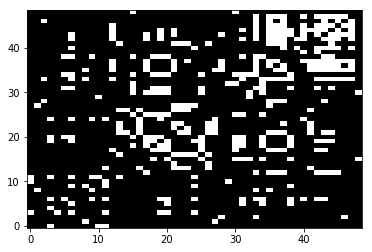

In [60]:
plt.imshow(A_or, aspect = 'auto', cmap = 'gray', origin = 'lower')

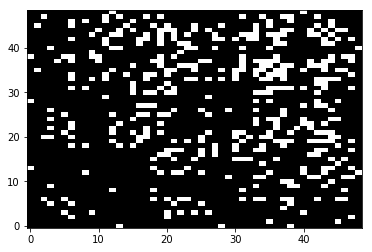

In [61]:
plt.imshow(A_rn, aspect = 'auto', cmap = 'gray', origin = 'lower')

In [42]:
a = A_or.sum(axis = 1)

In [43]:
b = A_rn.sum(axis = 1)

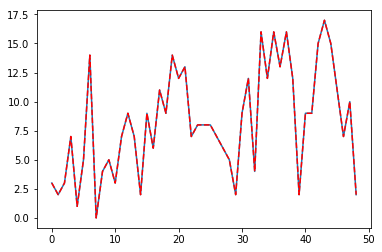

In [44]:
plt.plot(a)
plt.plot(b, 'r--')

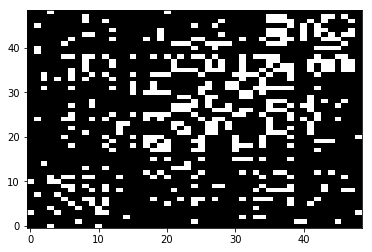

In [18]:
A = ( net.A[:,:,1,10] + np.transpose(net.A[:,:,1,10], (1,0)) ) > net.coh_thr[1]
plt.imshow(A, aspect = 'auto', cmap = 'gray', origin = 'lower')

In [82]:
'''
def radomize_graph(A, n_rewire = 10, seed = 0):
    np.random.seed(seed)
    Ar = A.copy()
    for i in range(A.shape[1]):
        idx     = np.concatenate(  (np.arange(0, i), 
                                    np.arange(i+1, Ar.shape[1]) ) )
        idx     = np.random.choice(idx, size = 2*n_rewire, replace=False)
        #print(idx_j)
        idx_j   = idx[:n_rewire]
        idx_k   = idx[n_rewire:]
        #print(idx_k)
        w_ij      = Ar[i,idx_j].copy()
        w_ik      = Ar[i,idx_k].copy()
        #print(idx)
        #w_rnd     = np.random.permutation(Ar[i,idx][i:])
        #print(w_rnd)
        Ar[i,idx_j] = w_ik
        Ar[i,idx_k] = w_ij
        #
        #Ar[:,i] = Ar[i,:]
        Ar[idx_j,i] = w_ik
        Ar[idx_k,i] = w_ij
    return Ar


def radomize_graph(A, n_rewire = 10, seed = 0):
    np.random.seed(seed)
    Ar      = A.copy()

    i, j    = np.random.randint(0, A.shape[0], n_rewire), \
              np.random.randint(0, A.shape[0], n_rewire), \

    idx     = np.array([i,j]).T
    idx     = np.unique(idx, axis = 0)
    
    k       = np.random.randint(0, A.shape[0], size=idx.shape[0])
    idx     = np.array([idx.T[0],idx.T[1],k]).T
    idx     = np.delete(idx, np.where(idx[:,0]==idx[:,1]), axis = 0)
    idx     = np.delete(idx, np.where(idx[:,0]==idx[:,2]), axis = 0).T
    
    w_ij    = A[idx[0],idx[1]].copy()
    w_ik    = A[idx[0],idx[2]].copy()
    
    Ar[idx[0],idx[1]] = Ar[idx[1],idx[0]] = w_ik
    Ar[idx[0],idx[2]] = Ar[idx[2],idx[0]] = w_ij
    return Ar

def radomize_graph(A, n_rewire = 10, seed = 0):
    np.random.seed(seed)
    Ar      = A.copy()
    for i in range(n_rewire):
        i = np.random.randint(0, A.shape[0],1)
        j = np.random.randint(0, A.shape[0],1)
        k = np.random.randint(0, A.shape[0],1)
        if i == j:
            while(i==j):
                j = np.random.randint(0, A.shape[0],1)
        if i == k:
            while(i==k):
                k = np.random.randint(0, A.shape[0],1)
    
        Ar[i,j] = Ar[j,i] = A[i,k]
        Ar[i,k] = Ar[k,i] = A[i,j]
    return Ar
'''
def randomize_graph(A, p_rewire = .1, seed = 0):
    Ar = A.copy()
    
    i, j   = np.where(A == 1)
    choice = np.random.rand(len(i)) < p_rewire
    k      = np.random.randint(0, A.shape[0], len(i[choice]))
    idx    = np.array([i[choice], j[choice], k])
    idx    = np.delete(idx, np.where(idx[:,0]==idx[:,2]), axis = 0)
    print(len(i[choice]))
    print(idx.shape)
    
    Ar[idx[0],idx[1]] = Ar[idx[1],idx[0]] = 0
    Ar[idx[0],idx[2]] = Ar[idx[2],idx[0]] = 1
    return Ar.astype(int)

170
(3, 170)


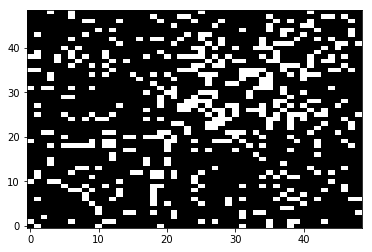

In [110]:
Ar = randomize_graph(A, p_rewire = .4, seed = 0)
plt.imshow(Ar, aspect = 'auto', cmap = 'gray', origin = 'lower')

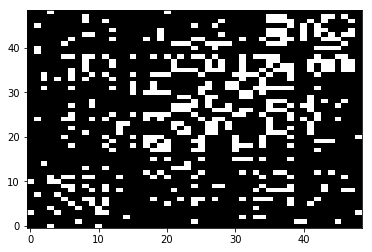

In [84]:
plt.imshow(A, aspect = 'auto', cmap = 'gray', origin = 'lower')

In [85]:
a = A.sum(axis = 1)

In [86]:
b = Ar.sum(axis = 1)

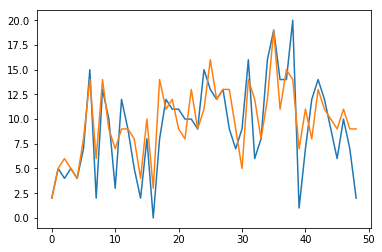

In [87]:
plt.plot(a)
plt.plot(b)

In [481]:
a.sum()

802.5720152383765

In [482]:
b.sum()

808.9895481734457

In [468]:
def check_symmetric(a, tol=1e-8):
    return np.all(np.abs(a-a.T) < tol)

In [470]:
check_symmetric(Ar, tol=1e-8)

True

In [489]:
A = net.A[:,:,1,:] + np.transpose(net.A[:,:,1,:], (1,0,2))
Ar= np.zeros_like(A)
for i in tqdm( range(A.shape[-1]) ):
    Ar[:,:,i] = radomize_graph(A[:,:,i], n_rewire = 1000, seed = 0)

  1%|          | 924/110160 [00:13<26:30, 68.68it/s]

KeyboardInterrupt: 

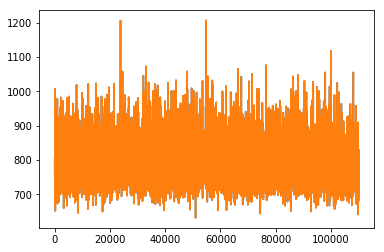

In [488]:
a = Ar.sum(axis=1).sum(axis =0)
b = A.sum(axis=1).sum(axis =0)
plt.plot(a)
plt.plot(b)

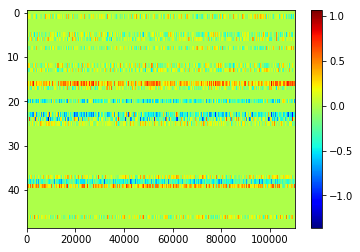

In [79]:
plt.imshow(a-b, aspect= 'auto', cmap = 'jet'); plt.colorbar()

In [471]:
def radomize_graph(A, n_rewire = 10, seed = 0):
    np.random.seed(seed)
    Ar      = A.copy()
    for i in range(n_rewire):
        i = np.random.randint(0, A.shape[0],1)
        j = np.random.randint(0, A.shape[0],1)
        k = np.random.randint(0, A.shape[0],1)
        if i == j:
            while(i==j):
                j = np.random.randint(0, A.shape[0],1)
        if i == k:
            while(i==k):
                k = np.random.randint(0, A.shape[0],1)
    
        Ar[i,j] = Ar[j,i] = A[i,k]
        Ar[i,k] = Ar[k,i] = A[i,j]
    return Ar

In [331]:
i       = 0
n_rewire= 20
idx     = np.concatenate(  (np.arange(0, i), 
                                    np.arange(i+1, A.shape[1]) ) )
idx     = np.random.choice(idx, size = 2*n_rewire, replace=False)
        #print(idx_j)
idx_j   = idx[:n_rewire]
idx_k   = idx[n_rewire:]

In [332]:
print(idx_j)
print(idx_k)

[15 24 14 17 47 30 45 31 41 40 32  4  7 48 46 19 25 37  5 29]
[26 38 36  1 44 22  2 13 39 10 35 43 20 27 11 34 28  8  9 23]


In [333]:
w_ij = A[i,idx_j].copy()
w_ik = A[i,idx_k].copy()

In [334]:
Arn = A.copy()

In [335]:
Arn[i,idx_j] = w_ik
Arn[i,idx_k] = w_ij

In [340]:
a = A[i,:]

In [341]:
b = Arn[i,:]

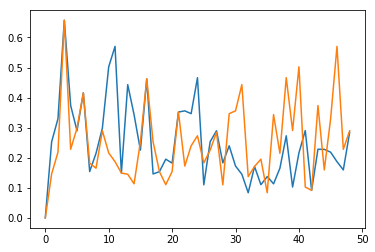

In [342]:
plt.plot(a)
plt.plot(b)

In [52]:
n_rewire = 10

In [144]:
i, j, k = np.random.randint(0,A.shape[0], 50000), \
          np.random.randint(0,A.shape[0], 50000), \
          np.random.randint(0,A.shape[0], 50000)

In [290]:
    i, j, k = np.random.randint(0, A.shape[0], 1000), \
              np.random.randint(0, A.shape[0], 1000), \
              np.random.randint(0, A.shape[0], 1000)
    
    idx     = np.array([i,j,k]).T
    idx     = np.delete(idx, np.where(idx[:,0]==idx[:,1]), axis = 0)
    idx     = np.delete(idx, np.where(idx[:,0]==idx[:,2]), axis = 0).T
    #idx     = np.unique(idx, axis = 1)

In [51]:
def create_edge_list(adj):
    import pandas as pd
    i,j = np.triu_indices_from(adj, k = -1)
    df  = pd.DataFrame(np.array([i,j,adj[i,j]]).T, columns=['i','j','w'] )
    df  = df[df.w != 0]
    return df.values[:,0:2]

def randomize_edges(adj, nrewires, seed):
    np.random.seed(seed)
    i     = 0
    edges = create_edge_list(adj)
    count = 1
    
    while i < nrewires:
        if i==0:
            Ar = adj.copy() 
            
        # Sampling two random edges
        e1, e2 = np.random.choice(range(edges.shape[0]), size=2, replace=False)
        # Saving original nodes
        a = edges[e1,0]
        b = edges[e1,1]
        c = edges[e2,0]
        d = edges[e2,1]
        # Check if the node number is the same to avoid auto-connections
        if a==d or c==b:
            continue
        #if Ar[a,d]==1 or Ar[d,a]==1 or Ar[c,b]==1 or Ar[b,c]==1:
        #    continue
        
        #edges[e1,1] = c
        #edges[e2,0] = b
        print(e1)
        print(e2)
        edges = np.delete(edges, [e1,e2], axis = 0)
        #edges = np.delete(edges, e2, axis = 0)
        edges = np.insert(edges, -1, [a,d], axis=0)
        edges = np.insert(edges, -1, [b,c], axis=0)
        # Create matrix 
        Ar = np.zeros_like(A)
        Ar[edges[:,0],edges[:,1]]=Ar[edges[:,1],edges[:,0]]=1  
        i+=1
    Ar = np.zeros_like(A)
    Ar[edges[:,0],edges[:,1]]=Ar[edges[:,1],edges[:,0]]=1
    return edges, Ar.astype(int)

In [52]:
A     = net.A[:,:,1,0]>net.coh_thr[1]
e, Ar = randomize_edges(A, 1000, 0)

18
171
110
47
49
190
139
120
181
75
45
43
6
108
35
159
130
170
199
156
33
178
144
102
126
39
151
167
39
126
49
75
110
73
128
148
18
99
172
166
90
48
34
46
174
17
72
130
190
53
40
142
37
48
123
161
122
19
9
190
20
77
37
97
80
160
18
171
142
158
45
44
90
44
115
138
31
21
126
167
19
51
179
153
201
93
83
119
67
180
122
153
117
111
168
133
74
144
83
37
198
56
56
75
116
156
172
1
161
117
74
140
129
104
157
32
11
80
7
25
45
154
165
141
77
52
189
201
146
71
62
112
41
128
39
104
66
179
87
139
124
133
12
113
45
31
112
81
78
155
95
101
132
84
143
71
167
190
94
36
146
192
171
99
123
100
54
70
98
153
91
99
193
151
14
112
37
164
65
48
53
175
17
39
26
144
22
182
196
163
10
57
70
9
115
15
103
36
22
67
61
59
23
65
149
114
21
179
48
4
193
15
5
99
43
145
148
53
69
32
197
171
145
29
146
84
20
65
192
85
199
84
51
59
34
29
28
75
161
188
123
52
65
102
193
40
124
126
166
107
54
147
55
114
103
60
74
32
141
151
84
107
28
156
148
137
56
143
167
42
9
137
188
141
197
107
46
25
71
158
131
102
86
177
131
10
170
187


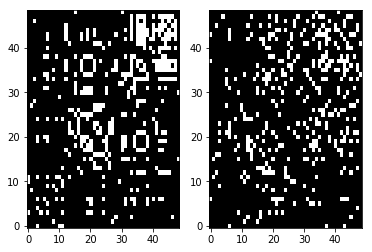

In [53]:
plt.subplot(1,2,1)
plt.imshow(A+A.T, aspect = 'auto', cmap = 'gray', origin = 'lower')
plt.subplot(1,2,2)
plt.imshow(Ar, aspect = 'auto', cmap = 'gray', origin = 'lower')

In [54]:
do = (A+A.T).sum(axis = 1)
dr = Ar.sum(axis = 1)

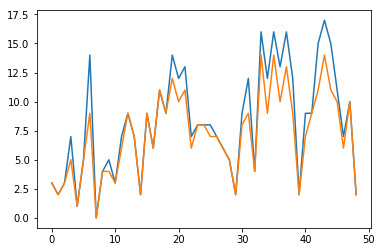

In [55]:
plt.plot(do)
plt.plot(dr)

In [56]:
do.sum()

404

In [57]:
dr.sum()

352

In [30]:
%timeit -n 100 randomize_edges(A, 1000, 0)

154 ms ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [31]:
n = np.arange(1,5000,20,dtype=int)
d = []
for i in range(n.shape[0]):
    e, Ar = randomize_edges(A, i, 10)
    d.append(Ar.sum(axis=1).sum())

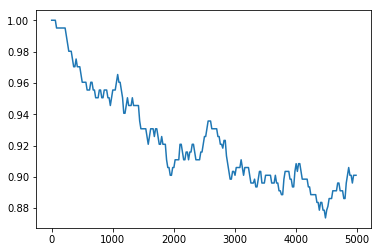

In [32]:
plt.plot(n, np.array(d)/((A+A.T).sum(axis=1).sum()))

In [33]:
A  = net.A[:,:,1,:]>net.coh_thr[1]
for i in tqdm(range(A.shape[-1])):
    e,Ar = randomize_edges(A[:,:,i], 100, 10)

  0%|          | 21/110160 [02:35<226:16:43,  7.40s/it]

KeyboardInterrupt: 

In [306]:
%timeit -n 100 randomize_edges(A[:,:,i], 100, 10)

KeyboardInterrupt: 

In [307]:
A[:,:,i].shape

(49, 49)

In [12]:
%timeit -n 1 net.create_null_model(band = 1, randomize='edges', thr=net.coh_thr[1], seed = 0)

2min 41s ± 416 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
ig

<module 'igraph' from '/home/vinicius/.local/lib/python3.6/site-packages/igraph/__init__.py'>

In [13]:
ig.igraph_rewire

AttributeError: module 'igraph' has no attribute 'igraph_rewire'

In [62]:
g = net.instantiate_graph(net.A[:,:,1,0], thr = net.coh_thr[1])

In [63]:
G = ig.Graph(net.A.shape[0], g.edges)

In [64]:
Gc = G.copy()

In [72]:
G.rewire(n=1000)

In [73]:
A = G.get_adjacency()

In [74]:
Ac = Gc.get_adjacency()

In [75]:
A = np.array(list(A))

In [76]:
Ac = np.array(list(Ac))

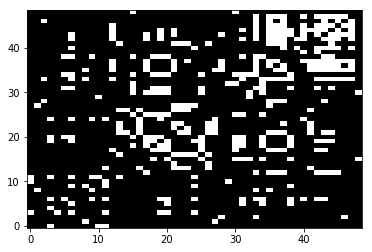

In [77]:
plt.imshow(Ac, aspect = 'auto', cmap = 'gray', origin = 'lower')

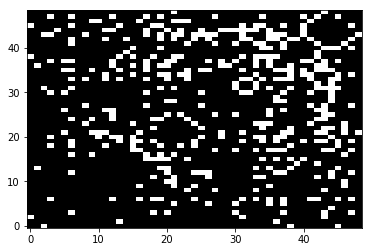

In [78]:
plt.imshow(A, aspect = 'auto', cmap = 'gray', origin = 'lower')

In [60]:
do = Ac.sum(axis = 1)
dr = A.sum(axis = 1)

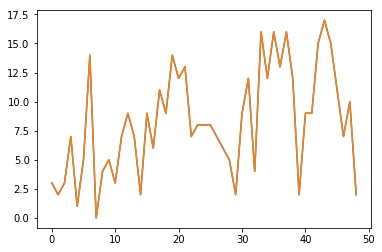

In [61]:
plt.plot(do)
plt.plot(dr)